In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os

os.cpu_count()

4

In [ ]:
import warnings

from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.simplefilter("ignore", ConvergenceWarning)
warnings.simplefilter("ignore", UserWarning)

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from forecasting import SalesForecaster
from IPython.display import clear_output, display
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.sarimax import SARIMAX
from sktime.utils.plotting import plot_windows
from tqdm.auto import tqdm

In [ ]:
# Объект главного класса для работы с прогнозированием
MAIN_CLASS = SalesForecaster()

# Путь к json файлу с метриками
# Сюда буду сохранять метрики для дальнейшего анализа
METRICS_JSON_PATH = Path("metrics.json")

# Горизонты прогнозирования
FORECAST_HORIZONS = [7, 30, 120]

# Подготовка данных

Подготовим данные для работы.  
Работаем с магазином STORE_1.  

Сделаем разбиение на train_val и test части.  

Временной диапазон длительный (почти 5 лет). Поэтому по идее мы даже сможем захватить годовую сезонность (так как для "захвата" сезонности требуется, чтобы было хотя бы 2 периода в train сплите).

План по сплиту данных: 
* train: фиксированно возьмем 2 года - сразу до val сплита
* val: пред-последний 1 год - чтобы валидировать работу модели на разных месяцах
* test: последние 4 месяца (квартал) - построим прогноз на последнюю неделю, месяц, квартал

In [ ]:
print(MAIN_CLASS.prepare_data.__doc__)
MAIN_CLASS.prepare_data(Path("../data"), store_id="STORE_1")


        Prepares the data for forecasting:
        - Loads sales, dates, prices data from CSV files.
        - Selects data for the specified store.
        - Merges the data into a single DataFrame.
        - Make some preprocessing with columns:
            - remove some unnecessary columns
            - renaming some columns
            - converting to needed types
        - Make training, validation, and test splits of sizes (2 years, 1 year, 4 months).
        - Saves the splits to CSV files with names: <store_id>_<item_id>_train_val.csv and <store_id>_<item_id>_test.csv.
        


Теперь все сплиты по каждому товару для магазина STORE_1 находятся в одной папке.

In [ ]:
sorted(file.name for file in Path("../data").iterdir() if file.name.startswith("STORE_1"))

['STORE_1_STORE_1_064_test.csv',
 'STORE_1_STORE_1_064_train_val.csv',
 'STORE_1_STORE_1_065_test.csv',
 'STORE_1_STORE_1_065_train_val.csv',
 'STORE_1_STORE_1_090_test.csv',
 'STORE_1_STORE_1_090_train_val.csv',
 'STORE_1_STORE_1_252_test.csv',
 'STORE_1_STORE_1_252_train_val.csv',
 'STORE_1_STORE_1_325_test.csv',
 'STORE_1_STORE_1_325_train_val.csv',
 'STORE_1_STORE_1_339_test.csv',
 'STORE_1_STORE_1_339_train_val.csv',
 'STORE_1_STORE_1_376_test.csv',
 'STORE_1_STORE_1_376_train_val.csv',
 'STORE_1_STORE_1_546_test.csv',
 'STORE_1_STORE_1_546_train_val.csv',
 'STORE_1_STORE_1_547_test.csv',
 'STORE_1_STORE_1_547_train_val.csv',
 'STORE_1_STORE_1_555_test.csv',
 'STORE_1_STORE_1_555_train_val.csv',
 'STORE_1_STORE_1_584_test.csv',
 'STORE_1_STORE_1_584_train_val.csv',
 'STORE_1_STORE_1_586_test.csv',
 'STORE_1_STORE_1_586_train_val.csv',
 'STORE_1_STORE_1_587_test.csv',
 'STORE_1_STORE_1_587_train_val.csv',
 'STORE_1_STORE_1_714_test.csv',
 'STORE_1_STORE_1_714_train_val.csv',
 'STOR

Посмотрим на ВР для товара 727:

In [ ]:
train_val = pd.read_csv(Path("../data/STORE_1_STORE_1_727_train_val.csv"))
train_val.date = pd.to_datetime(train_val.date)
train_val.head()

item_id  date_id  cnt       date  wday event_name_1 event_type_1  \
0  STORE_1_727      604    0 2012-09-23     2          NaN          NaN   
1  STORE_1_727      605    2 2012-09-24     3          NaN          NaN   
2  STORE_1_727      606    5 2012-09-25     4          NaN          NaN   
3  STORE_1_727      607    2 2012-09-26     5          NaN          NaN   
4  STORE_1_727      608    0 2012-09-27     6          NaN          NaN   

  event_name_2 event_type_2  cashback  sell_price  day  month  year  
0          NaN          NaN         0        3.98   23      9  2012  
1          NaN          NaN         0        3.98   24      9  2012  
2          NaN          NaN         0        3.98   25      9  2012  
3          NaN          NaN         0        3.98   26      9  2012  
4          NaN          NaN         0        3.98   27      9  2012

In [ ]:
train_val.date.min(), train_val.date.max()

(Timestamp('2012-09-23 00:00:00'), Timestamp('2015-09-23 00:00:00'))

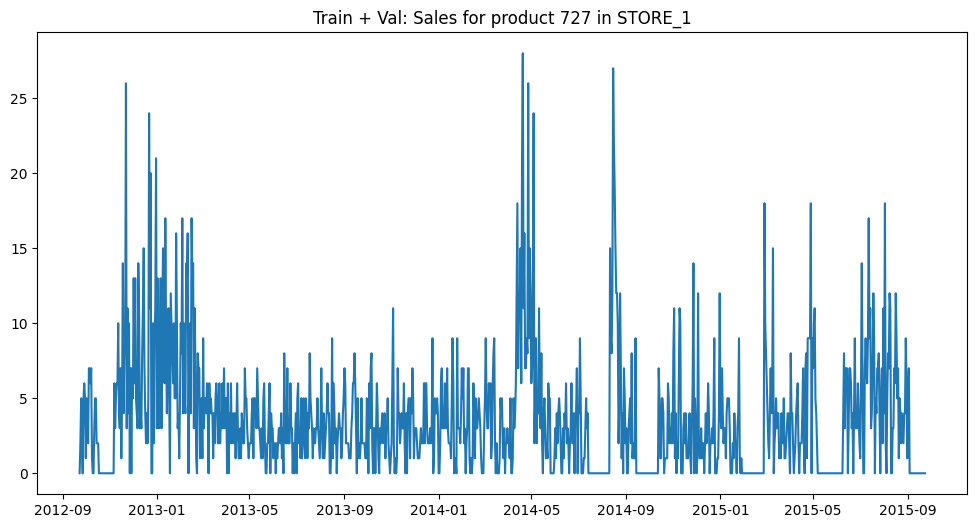

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_val.date, train_val.cnt)
plt.title("Train + Val: Sales for product 727 in STORE_1")
plt.show()

In [ ]:
test = pd.read_csv(Path("../data/STORE_1_STORE_1_727_test.csv"))
test.date = pd.to_datetime(test.date)
test.head()

item_id  date_id  cnt       date  wday event_name_1 event_type_1  \
0  STORE_1_727     1700    0 2015-09-24     6    EidAlAdha    Religious   
1  STORE_1_727     1701    0 2015-09-25     7          NaN          NaN   
2  STORE_1_727     1702    0 2015-09-26     1          NaN          NaN   
3  STORE_1_727     1703    0 2015-09-27     2          NaN          NaN   
4  STORE_1_727     1704    0 2015-09-28     3          NaN          NaN   

   event_name_2  event_type_2  cashback  sell_price  day  month  year  
0           NaN           NaN         0        3.33   24      9  2015  
1           NaN           NaN         0        3.33   25      9  2015  
2           NaN           NaN         0        3.33   26      9  2015  
3           NaN           NaN         0        3.33   27      9  2015  
4           NaN           NaN         0        3.33   28      9  2015

In [ ]:
test.date.min(), test.date.max()

(Timestamp('2015-09-24 00:00:00'), Timestamp('2016-01-21 00:00:00'))

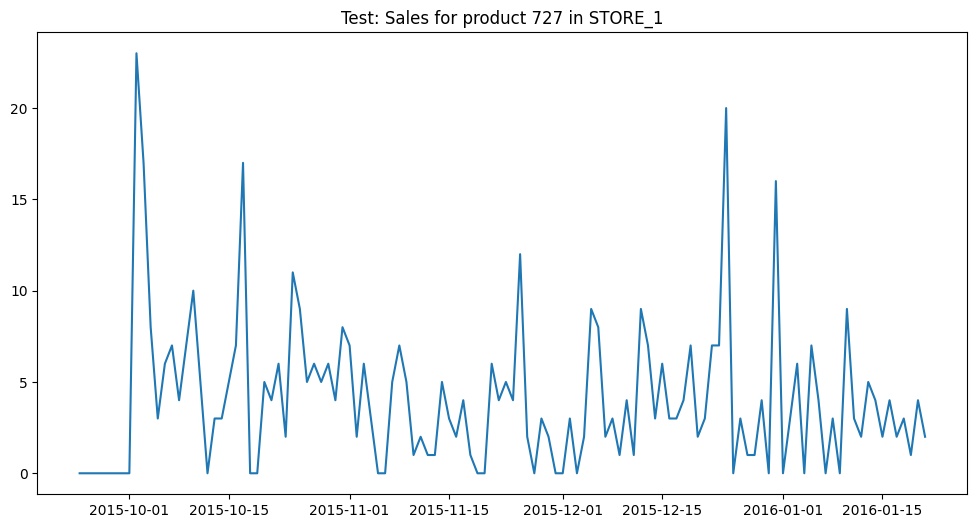

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test.date, test.cnt)
plt.title("Test: Sales for product 727 in STORE_1")
plt.show()

In [ ]:
# Вспомогательные переменные
ITEM_IDS = [
    "STORE_1_064",
    "STORE_1_065",
    "STORE_1_090",
    "STORE_1_252",
    "STORE_1_325",
    "STORE_1_339",
    "STORE_1_376",
    "STORE_1_546",
    "STORE_1_547",
    "STORE_1_555",
    "STORE_1_584",
    "STORE_1_586",
    "STORE_1_587",
    "STORE_1_714",
    "STORE_1_727",
]
ITEM_ID_2_TRAIN_VAL_TEST = {
    item_id: (
        pd.read_csv(Path(f"../data/STORE_1_{item_id}_train_val.csv")),
        pd.read_csv(Path(f"../data/STORE_1_{item_id}_test.csv")),
    )
    for item_id in ITEM_IDS
}

# Функции для обучения, валидации и тестирования моделей

In [ ]:
def cross_validate(
    forecaster,
    param_grid,
    fh,
    item_id,
    model_name,
    save_best=True,
    replace_zeros=None,
    use_custom_cv=False,
    exog_cols=[],
):
    """
    Cross-validate forecaster with the given parameter grid and forecasting horizon for given item and save the best models.

    Params:
        forecaster: The forecaster to be cross-validated.
        param_grid: The parameter grid to search over.
        fh: The forecasting horizon.
        item_id: The ID of the item.
        model_name: The name of the model.
        save_best: Whether to save the best model.
        replace_zeros: Value to replace zeros in the target variable.
        use_custom_cv: Whether to use custom cross-validation (with error skipping).
        exog_cols: List of external feature columns.
    """
    train_val = ITEM_ID_2_TRAIN_VAL_TEST[item_id][0].copy()
    if replace_zeros:
        train_val["cnt"] = train_val["cnt"].replace(0, replace_zeros)

    if use_custom_cv:
        cv_func = MAIN_CLASS.custom_cross_validate_forecaster
    else:
        cv_func = MAIN_CLASS.cross_validate_forecaster

    _, best_forecaster = cv_func(
        forecaster=forecaster.clone(), train_val=train_val, param_grid=param_grid, fh=fh, exog_cols=exog_cols
    )
    if save_best:
        MAIN_CLASS.save_model(
            best_forecaster, Path(f"../models/{model_name}/STORE_1__{item_id}__fh_{fh}__{model_name}")
        )


def forecast_and_evaluate(fh: int, model_name: str, params: list[str], save_results_to_json: bool = True) -> dict:
    """
    Loads best models for each item_id (using parameter `fh` and `model_name`),
    make forecast and evaluate it against the test set.

    Returns dict with item_id as keys and a tuple of (best_params: str, forecast: pd.Series, metrics: dict) as values.

    Params:
        fh (int): Forecasting horizon.
        model_name (str): Name of the model to load.
        params (list[str]): List of parameters that were cross-validated and need to be added in results.
        save_results_to_json (bool): If True, saves results to JSON file.
    """
    results = {}

    for item_id in tqdm(ITEM_IDS, desc="Items", leave=False):
        try:
            best_forecaster = MAIN_CLASS.load_model(
                Path(f"../models/{model_name}/STORE_1__{item_id}__fh_{fh}__{model_name}")
            )
            test = ITEM_ID_2_TRAIN_VAL_TEST[item_id][1]

            forecast = MAIN_CLASS.forecast(best_forecaster, fh)
            metrics = MAIN_CLASS.calculate_metrics(
                forecast.reset_index(drop=True), test.cnt[:fh].reset_index(drop=True)
            )
            best_params = ", ".join(f"{k}={v}" for k, v in best_forecaster.get_params().items() if k in params)
            results[item_id] = (best_params, forecast, metrics)
        except:
            pass

    if save_results_to_json:
        utils.save_metrics_to_json(model_name, fh, results, METRICS_JSON_PATH)

    return results

# Функции для визуализации

In [ ]:
def all_items_evaluation_report(results: dict):
    """
    Generates a report for the evaluation results of all items.
    Construct pd.DataFrame with metrics and plots the forecasts (as 5x3 subplots grid).
    """
    # Construct report DataFrame
    metrics_list = []
    for item_id in sorted(ITEM_IDS):
        if item_id in results:
            best_params, _, metrics = results[item_id]
            metrics_row = {"item_id": item_id, "best_params": best_params}
            metrics_row.update(metrics)
            metrics_list.append(metrics_row)
    metrics_df = pd.DataFrame(metrics_list).set_index("item_id")

    avg_row = metrics_df.drop(columns="best_params").mean(numeric_only=True)
    avg_row.name = "AVERAGE"
    avg_row["best_params"] = ""
    metrics_df = pd.concat([metrics_df, avg_row.to_frame().T])
    display(metrics_df)

    # Plot forecasts vs ground truth for all items
    fig, axes = plt.subplots(5, 3, figsize=(20, 15), sharex=True)
    axes = axes.flatten()
    for i, item_id in enumerate(ITEM_IDS):
        if item_id in results:
            _, forecast, _ = results[item_id]
            test = ITEM_ID_2_TRAIN_VAL_TEST[item_id][1]
            axes[i].plot(test.cnt[: len(forecast)].reset_index(drop=True), label="Ground Truth")
            axes[i].plot(forecast.reset_index(drop=True), label="Forecast")
            axes[i].set_title(item_id)
            axes[i].legend()
    plt.tight_layout()
    plt.show()


def one_item_multiple_models_evaluation_report(item_id: str, models: list[str], forecast_horizons: list[int]):
    # Collect results (best_params, metrics) from previous runs from `metrics.json`
    tables = {}
    for fh in forecast_horizons:
        rows = []
        for model in models:
            best_params, metrics = utils.load_info_from_json(METRICS_JSON_PATH, fh, model, item_id)
            row = {
                "model": model,
                "best_params": best_params,
                "MAE": metrics["MAE"],
                "SMAPE": metrics["SMAPE"],
                "R2": metrics["R2"],
            }
            rows.append(row)
        tables[fh] = pd.DataFrame(rows).set_index("model")

    # Plot results and forecasts
    for fh in forecast_horizons:
        print("=" * 119)
        print(f"{'Results for ' + item_id + ' (horizon=' + str(fh) + ' days):':^119}")
        display(tables[fh])

        plt.figure(figsize=(12, 6))
        test_data = ITEM_ID_2_TRAIN_VAL_TEST[item_id][1]
        plt.plot(test_data.cnt[:fh].reset_index(drop=True), label="Ground Truth", linewidth=2, color="black")

        for model in models:
            results = forecast_and_evaluate(fh, model, [], False)
            _, forecast, _ = results[item_id]
            plt.plot(forecast.reset_index(drop=True), label=model)

        plt.title(f"Forecasts for {item_id} (horizon={fh} days)")
        plt.xlabel("Day")
        plt.ylabel("Sales")
        plt.legend()
        plt.show()
        print("=" * 119)
        print()


def avg_metrics_multiple_models_report(models: list[str], forecast_horizons: list[int]):
    for fh in forecast_horizons:
        rows = []
        print("=" * 119)
        print(f"Forecast horizon: {fh} days")
        for model in models:
            avg_metrics = utils.load_avg_metrics_from_json(METRICS_JSON_PATH, fh, model)
            row = {
                "model": model,
                "MAE": avg_metrics["MAE"],
                "SMAPE": avg_metrics["SMAPE"],
                "R2": avg_metrics["R2"],
            }
            rows.append(row)
        display(pd.DataFrame(rows).set_index("model"))
        print("=" * 119)
        print()

# Про метрики

В качестве метрик возьму следующие:
* MAE - стандартная метрика регресии, при аггрегации между разными ВР (а у нас у разных ВР разный масштаб продаж) необходимо взвешивание
* SMAPE - симметричный вариант процентной ошибки, более репрезентативные значения (у MAE это совсем не так). SMAPE хороша тут еще потому что у нас бывают нули во ВР.
* R2 - интересно сравнивать предсказания наших моделей со средним предсказанием

Соответственно итоговое качество модели мы будем оценивать на отложенной выборке размера 120 дней (будем проверять прогнозы на неделю, месяц, квартал).  
Для разных горизонтов прогнозирования из тестовой выборки берутся соответствующие части:
- горизонт 7 дней: беру первые 7 дней из тестовой выборки,
- горизонт 30 дней: беру первые 30 дней из тестовой выборки,
- горизонт 120 дней: беру всю тестовую выборку (она 120 дней).

Это сделано так, так как финальная модель обучается на последних 2 годах данных, не включая тестовую выборку (120 дней).

# Про кросс-валидацию

Для подбора гиперпараметров использую time-series cross-validation.  
Буду обучать 3 отдельных модели для разных горизонтов прогнозирования: 7 дней, 30 дней и 120 дней. Для каждого горизонта будет свой шаг скользящего окна, чтобы получить ровно 10 train-val сплитов:
* для горизонта 7 дней: шаг 38 дней,
* для горизонта 30 дней: шаг 35 дней,
* для горизонта 120 дней: шаг 25 дней.

Таким образом, для каждого горизонта будет проведено по 10 train-val разбиений для оценки качества модели.

То есть для каждого набора параметров будем обучать модель на 10 наборах train-val и в качестве итоговой модели будем брать модель обученную на последних 2-х годах данных.

Провизуализируем CV сплиты.

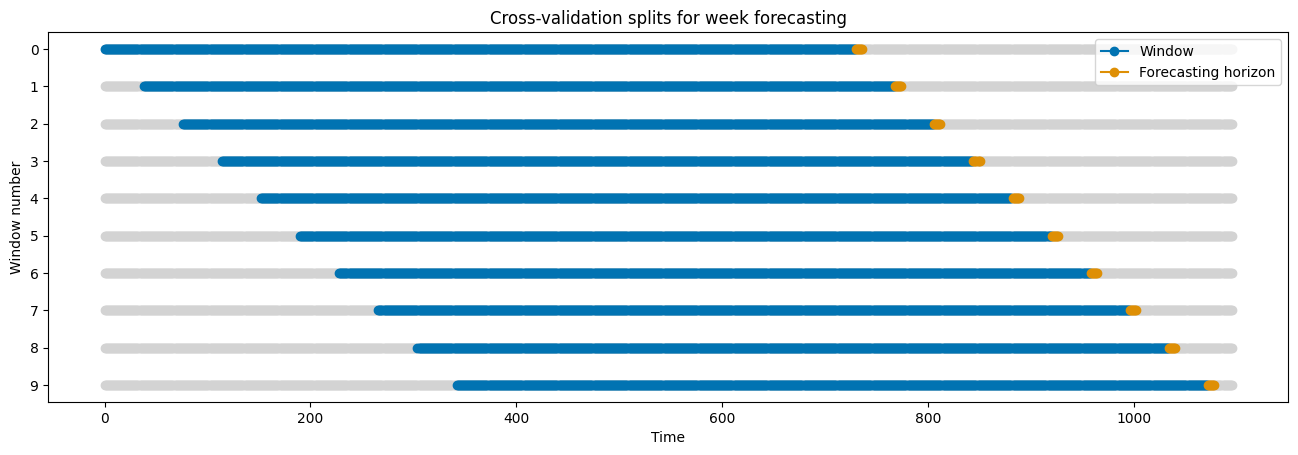

In [ ]:
cv = SlidingWindowSplitter(fh=np.arange(1, 8), window_length=365 * 2, step_length=38)
plot_windows(cv, train_val.cnt)
plt.title("Cross-validation splits for week forecasting")
plt.show()

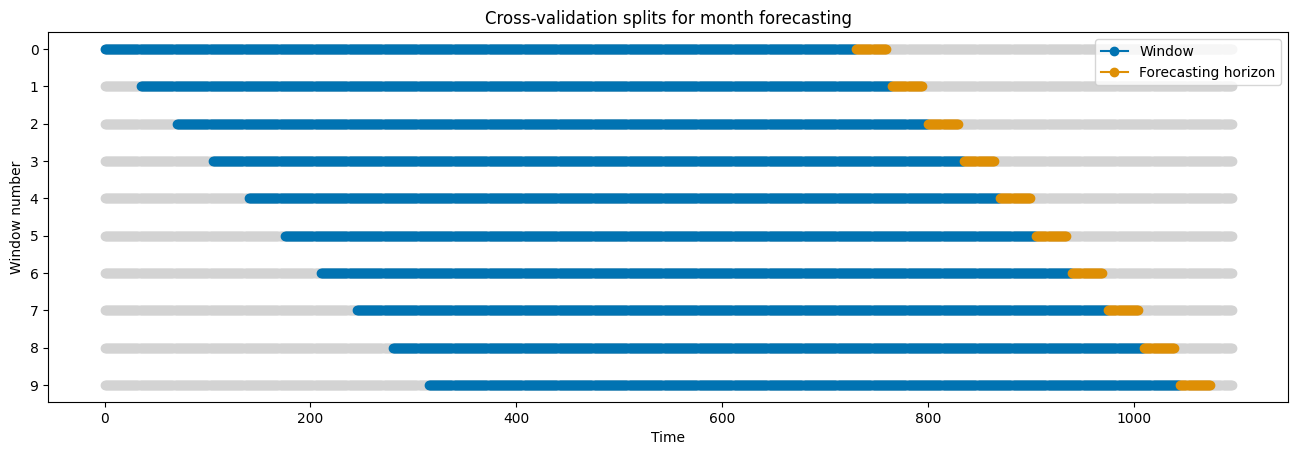

In [ ]:
cv = SlidingWindowSplitter(fh=np.arange(1, 31), window_length=365 * 2, step_length=35)
plot_windows(cv, train_val.cnt)
plt.title("Cross-validation splits for month forecasting")
plt.show()

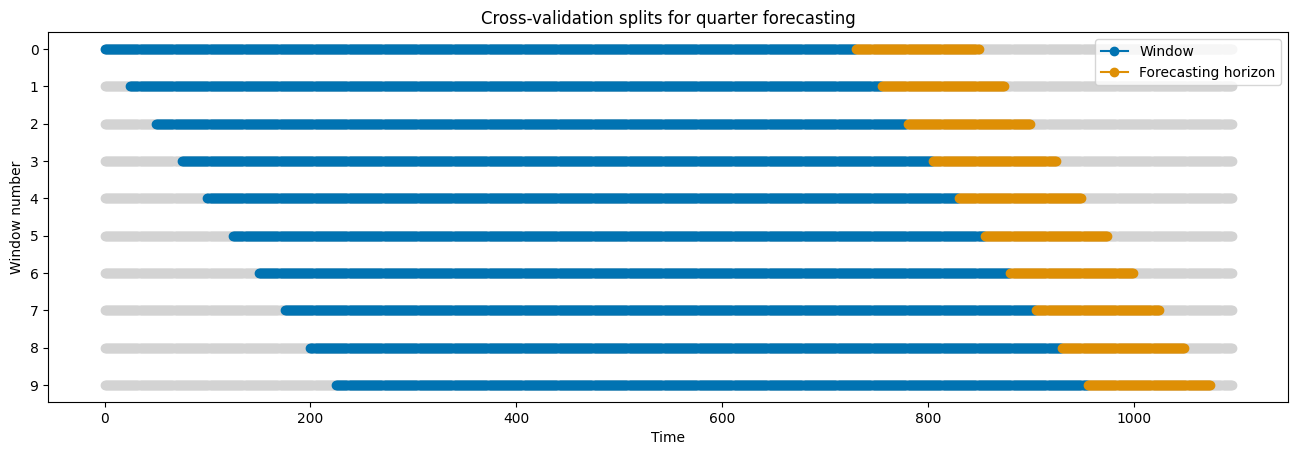

In [ ]:
cv = SlidingWindowSplitter(fh=np.arange(1, 121), window_length=365 * 2, step_length=25)
plot_windows(cv, train_val.cnt)
plt.title("Cross-validation splits for quarter forecasting")
plt.show()

# Наивные модели

Попробуем наивные модели из sktime NaiveForecaster:
* last (подберем параметр sp (seasonal periodicity) на CV)
* mean (подберем параметры sp и window_length на CV)
* drift (доп параметров нет)

## Naive: last

In [ ]:
forecaster = NaiveForecaster(strategy="last")
param_grid = {"sp": [1, 7, 30, 120, 365]}

for fh in tqdm(FORECAST_HORIZONS, desc="Horizons", leave=False):
    for item_id in tqdm(ITEM_IDS, desc="Items", leave=False):
        cross_validate(forecaster, param_grid, fh, item_id, model_name="naive_last")
clear_output()

In [ ]:
results = {}
for fh in tqdm(FORECAST_HORIZONS, desc="Horizons", leave=False):
    results[fh] = forecast_and_evaluate(fh, model_name="naive_last", params=["sp"])
clear_output()

                                              Results for horizon 7 days:                                              


best_params        MAE     SMAPE         R2
STORE_1_064       sp=30        0.0       0.0        1.0
STORE_1_065        sp=7        1.0  0.857143  -0.294521
STORE_1_090        sp=1  35.142857  0.583859  -0.943726
STORE_1_252      sp=120   7.428571  0.517711  -0.716981
STORE_1_325        sp=1   3.857143  0.965883  -0.001075
STORE_1_339        sp=7        0.0       0.0        1.0
STORE_1_376        sp=1   0.428571  0.571429  -0.346154
STORE_1_546        sp=7   2.857143  0.879307   0.444676
STORE_1_547        sp=7   7.285714  1.148526  -4.698438
STORE_1_555        sp=1   6.857143  0.391416  -0.011992
STORE_1_584      sp=365   1.285714  0.619048 -15.916667
STORE_1_586        sp=7   9.571429  0.331288  -0.380787
STORE_1_587        sp=7  11.142857   0.39868  -0.747522
STORE_1_714        sp=1   3.285714  0.158595  -0.090807
STORE_1_727        sp=1        0.0       0.0        1.0
AVERAGE                   6.009524  0.494859  -1.380266

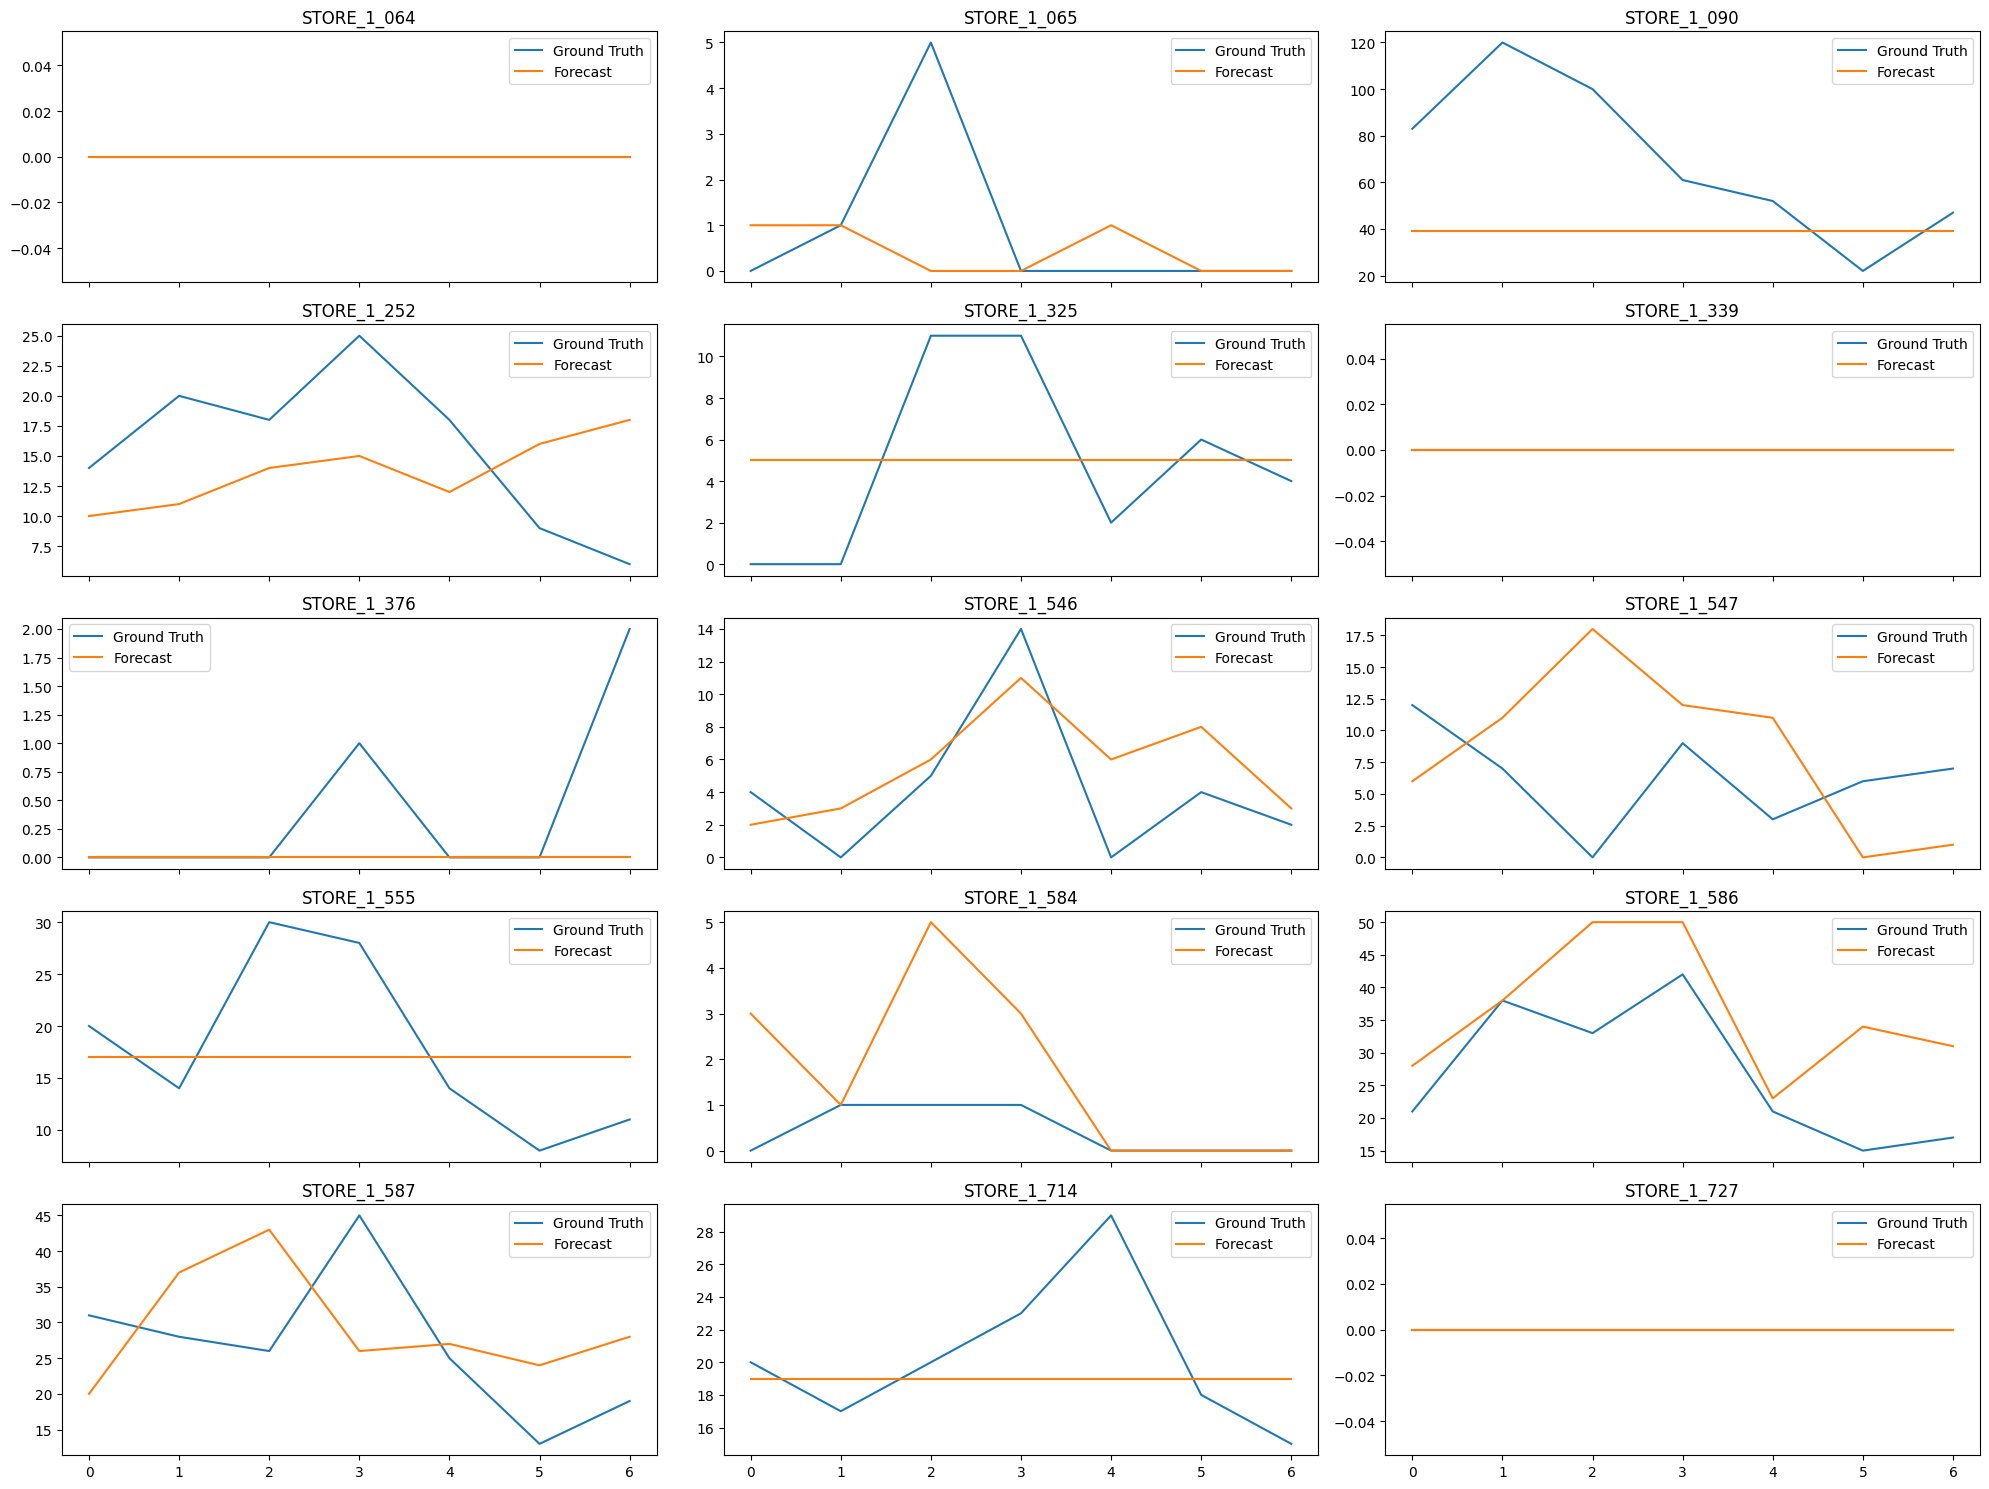



                                             Results for horizon 30 days:                                              


best_params        MAE     SMAPE        R2
STORE_1_064      sp=120        0.2  0.333333 -3.285714
STORE_1_065      sp=365   0.566667       0.8 -0.433824
STORE_1_090        sp=1  35.733333  0.571578 -1.651772
STORE_1_252        sp=7   8.433333  0.482443 -0.975751
STORE_1_325      sp=365   4.366667  0.997732 -0.838782
STORE_1_339        sp=7        2.1       1.0 -0.578487
STORE_1_376        sp=1        0.6  0.733333 -0.325301
STORE_1_546        sp=1   2.066667  0.625042 -0.108049
STORE_1_547        sp=1       10.0  1.486803 -0.886383
STORE_1_555      sp=365   8.366667   0.44448 -0.970935
STORE_1_584        sp=7        1.5  1.138413 -0.704545
STORE_1_586      sp=365        9.7   0.29157 -0.401982
STORE_1_587        sp=7   9.433333  0.307501 -0.403459
STORE_1_714        sp=1   4.566667   0.20209 -0.575673
STORE_1_727        sp=1   4.733333  1.266667 -0.703166
AVERAGE                   6.824444  0.712066 -0.856255

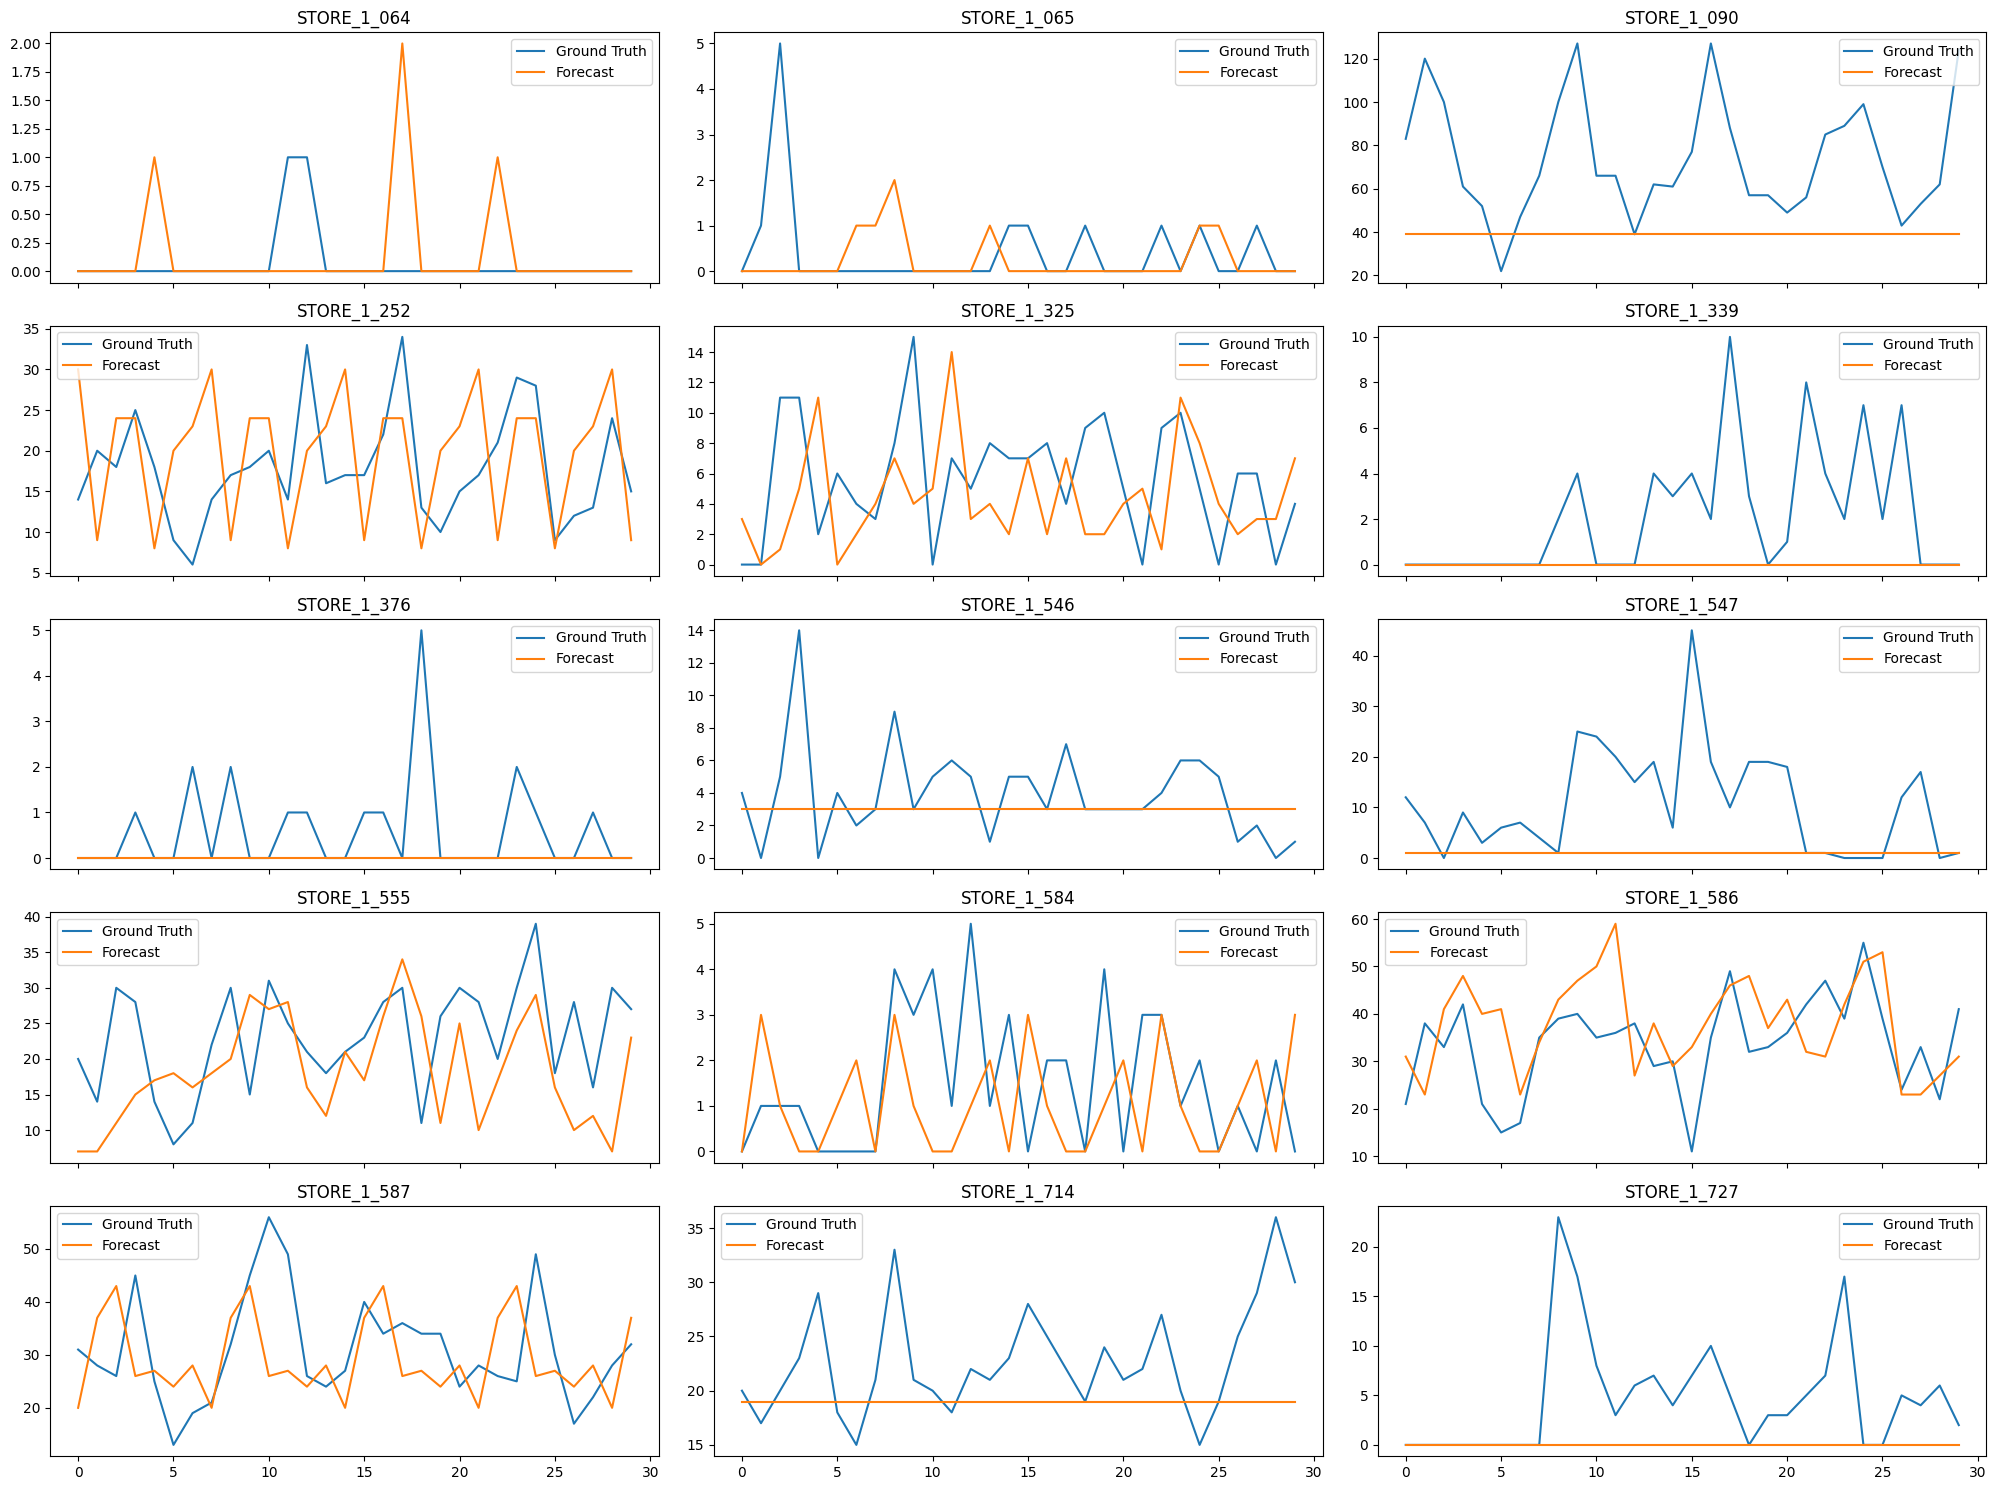



                                             Results for horizon 120 days:                                             


best_params        MAE     SMAPE        R2
STORE_1_064      sp=120      0.375  0.501389 -2.549863
STORE_1_065      sp=365   0.666667  0.741667 -0.344097
STORE_1_090      sp=365  23.758333  0.382546  0.336269
STORE_1_252        sp=1   9.108333  0.522055 -0.868986
STORE_1_325      sp=365       4.15  0.941764 -0.444331
STORE_1_339        sp=1   3.158333  1.533333 -1.287117
STORE_1_376      sp=120   0.841667  0.846032 -0.977612
STORE_1_546        sp=7       2.95  0.737696 -1.779233
STORE_1_547      sp=365       12.7  1.483571  -1.00017
STORE_1_555      sp=365   8.166667  0.399635 -0.635164
STORE_1_584        sp=1   1.566667  1.071534 -0.053502
STORE_1_586      sp=365   9.416667  0.288387 -0.164092
STORE_1_587        sp=1        7.6  0.256703 -0.128281
STORE_1_714       sp=30   9.708333  0.418525  -2.07031
STORE_1_727      sp=120   4.083333  1.115672 -0.845146
AVERAGE                       6.55  0.749367 -0.854109

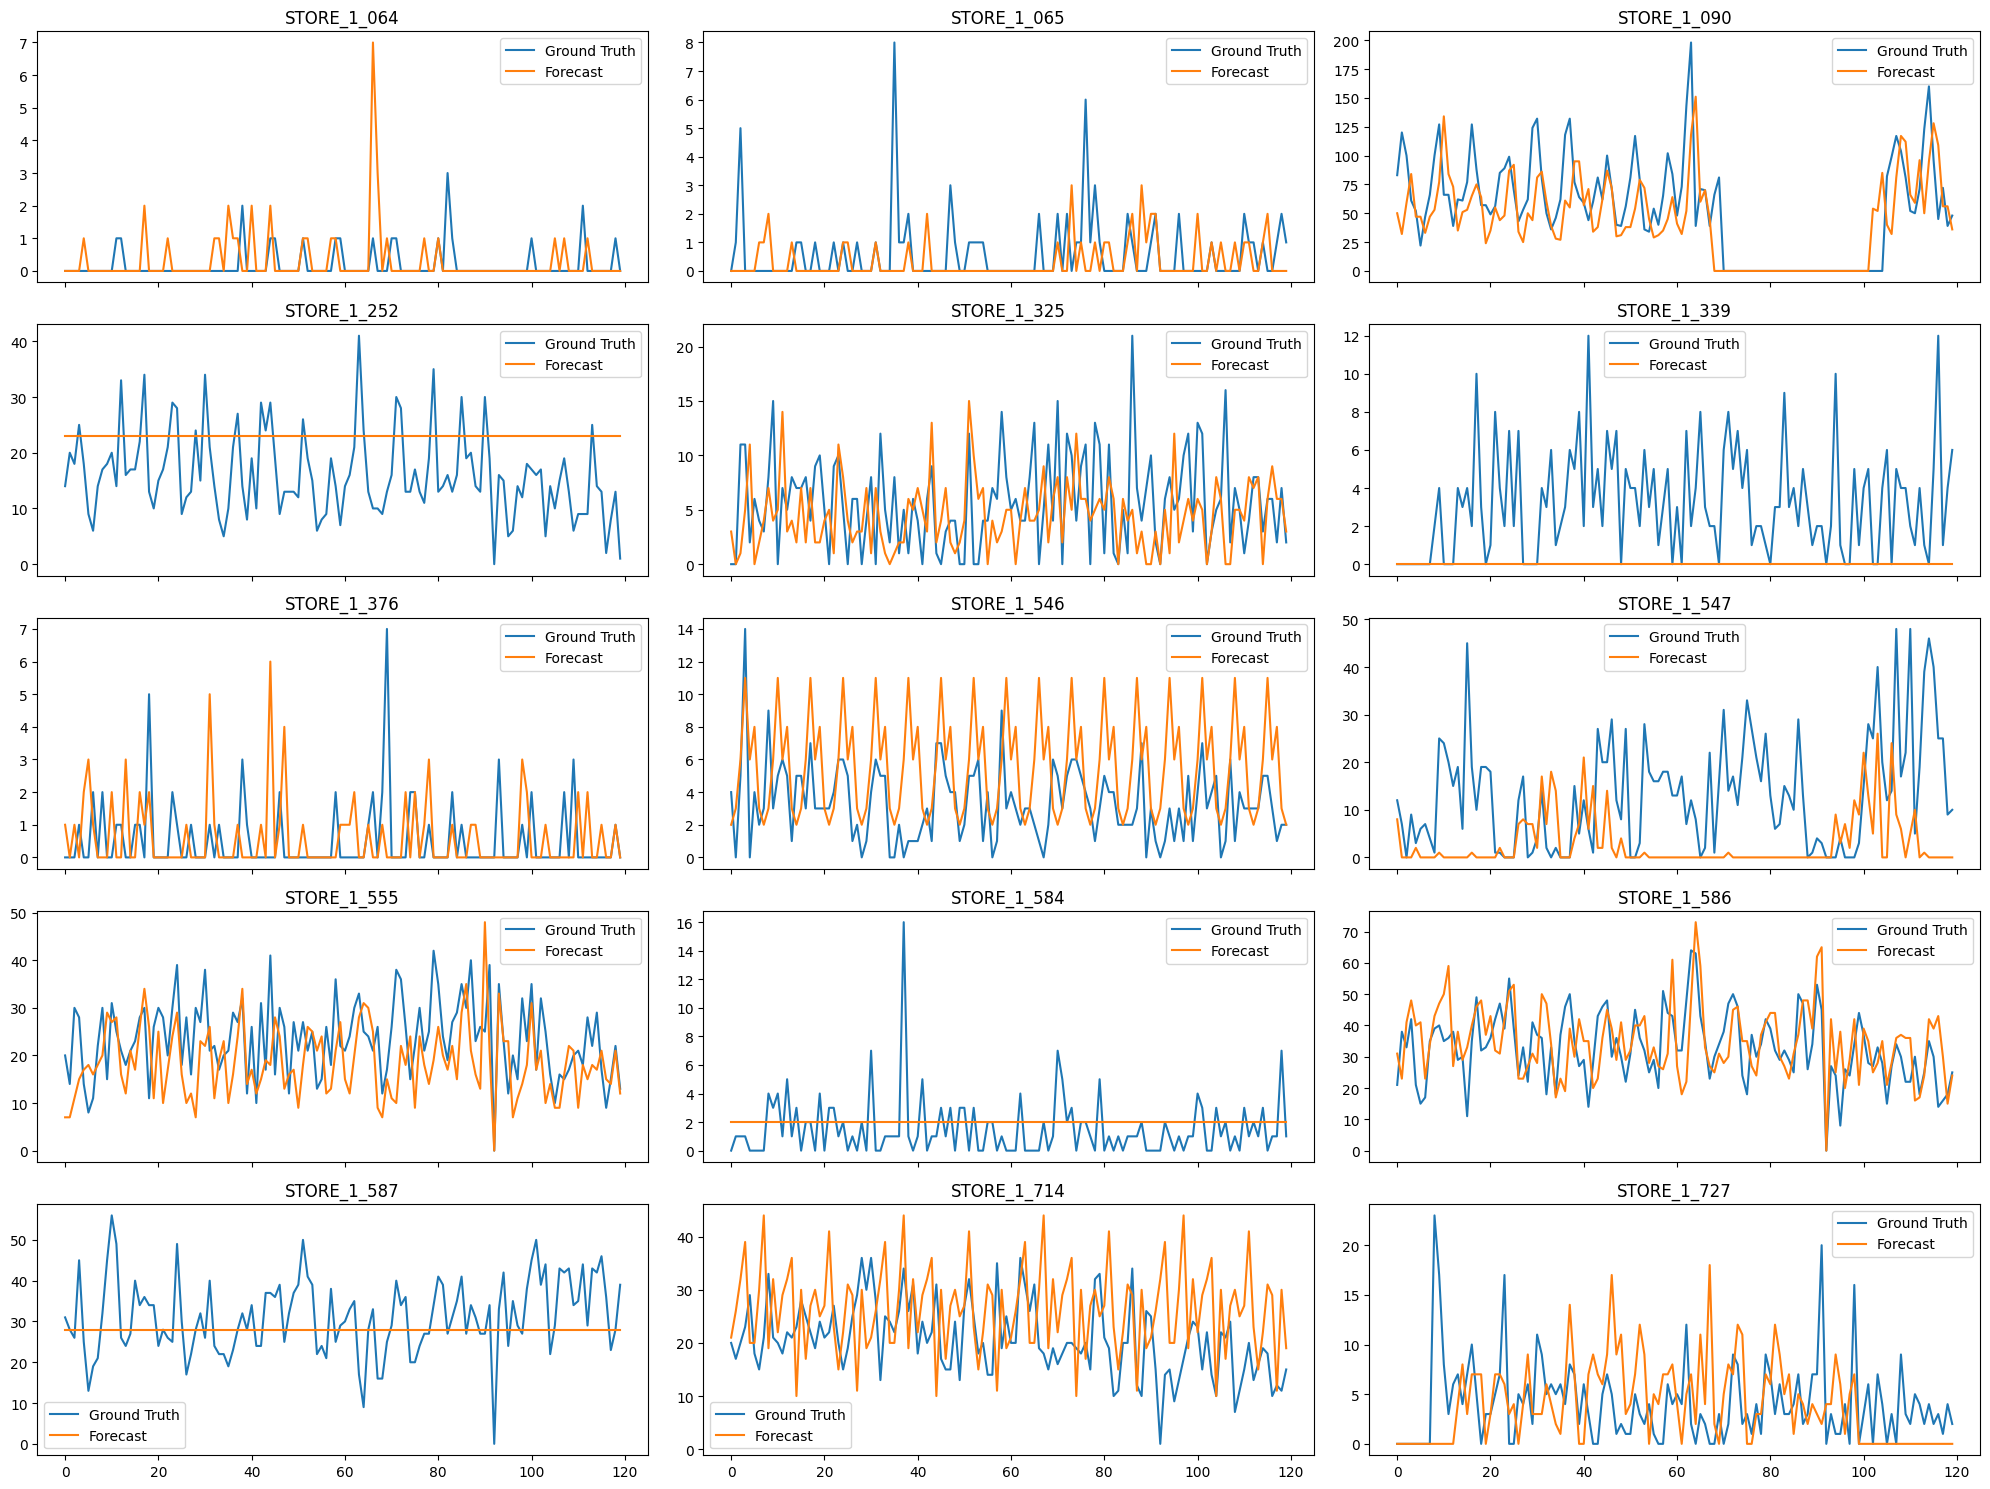

In [ ]:
for fh in FORECAST_HORIZONS:
    print("=" * 119)
    print(f"{'Results for horizon ' + str(fh) + ' days:':^119}")
    all_items_evaluation_report(results[fh])
    print("=" * 119)
    print("\n")

В процессе EDA ([eda.ipynb](./report_1__eda.ipynb)) было проанализировано, что ни в одном ряде нет четкой сезонности (везде период разный), однако были ряды в которых сезонность была более заметна.

В этом убеждаемся, если смотрим на предсказания наивной модели last (предсказывает последние значения). Для некоторых товаров по кросс-валидации были выбраны модели с сезонностью 7 (параметр sp - значит мы берем прошлое значение из последнего сезонного цикла). Можно увидеть, что для таких рядов предсказания довольно неплохие:
* STORE_1_546 - на графиках прогноза на 120 дней
* STORE_1_587 - на графиках прогноза на 30 дней

## Naive: mean

In [ ]:
forecaster = NaiveForecaster(strategy="mean")
param_grid = {"window_length": [1, 3, 5, 10, None]}

for fh in tqdm(FORECAST_HORIZONS, desc="Horizons", leave=False):
    for item_id in tqdm(ITEM_IDS, desc="Items", leave=False):
        cross_validate(forecaster, param_grid, fh, item_id, model_name="naive_mean")
clear_output()

In [ ]:
results = {}
for fh in tqdm(FORECAST_HORIZONS, desc="Horizons", leave=False):
    results[fh] = forecast_and_evaluate(fh, model_name="naive_mean", params=["window_length"])
clear_output()

                                              Results for horizon 7 days:                                              


best_params        MAE     SMAPE         R2
STORE_1_064     window_length=1        0.0       0.0        1.0
STORE_1_065     window_length=1   0.857143  0.571429  -0.246575
STORE_1_090     window_length=3  27.285714  0.421807  -0.307429
STORE_1_252    window_length=10   6.857143  0.423916  -0.941976
STORE_1_325    window_length=10        3.8  1.049283  -0.111871
STORE_1_339    window_length=10        0.0       0.0        1.0
STORE_1_376     window_length=1   0.428571  0.571429  -0.346154
STORE_1_546     window_length=5   4.714286  1.017906  -0.361127
STORE_1_547     window_length=1   5.571429  1.531554  -2.139063
STORE_1_555     window_length=5   7.714286  0.429855  -0.161226
STORE_1_584  window_length=None   1.633072  1.440077 -10.889946
STORE_1_586  window_length=None  10.477691  0.385103  -0.455093
STORE_1_587     window_length=5   7.685714   0.28974  -0.096281
STORE_1_714    window_length=10   5.714286  0.263349  -1.119462
STORE_1_727     window_length=1        0.0       0.0        1.0
AVERAGE                           5.515956  0.559697   -0.94508

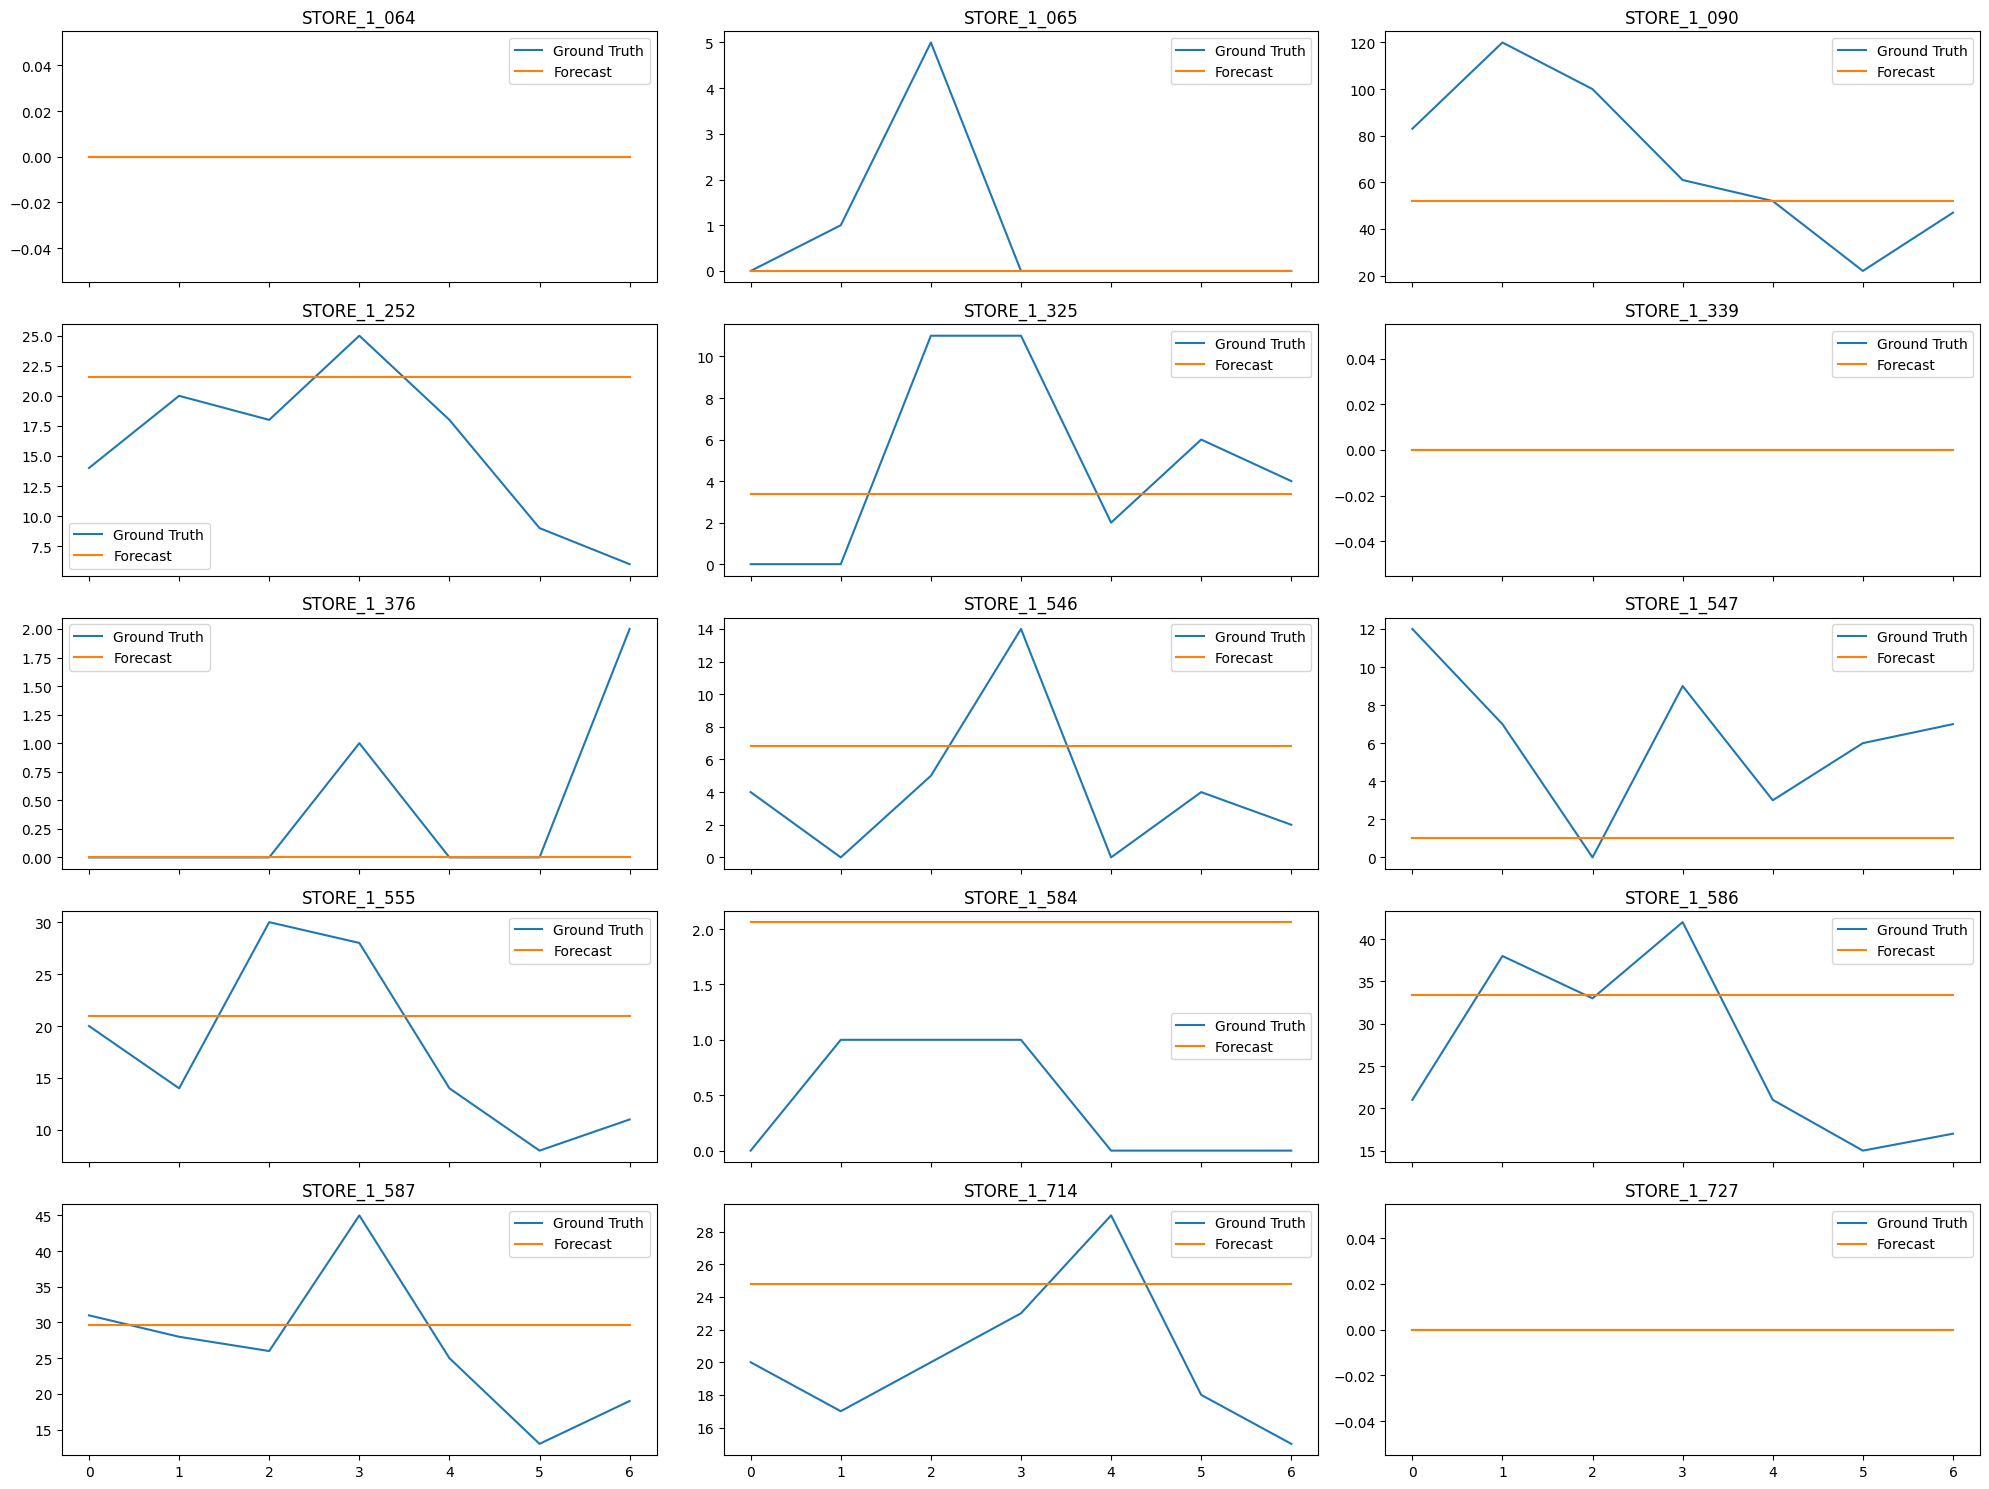



                                             Results for horizon 30 days:                                              


best_params        MAE     SMAPE        R2
STORE_1_064     window_length=1   0.066667  0.133333 -0.071429
STORE_1_065     window_length=1        0.4  0.533333 -0.176471
STORE_1_090     window_length=1  35.733333  0.571578 -1.651772
STORE_1_252    window_length=10   6.586667  0.358065 -0.298795
STORE_1_325  window_length=None   3.150411  0.696794 -0.000398
STORE_1_339  window_length=None    2.58758  1.243069 -0.155185
STORE_1_376     window_length=1        0.6  0.733333 -0.325301
STORE_1_546     window_length=1   2.066667  0.625042 -0.108049
STORE_1_547     window_length=1       10.0  1.486803 -0.886383
STORE_1_555    window_length=10   6.306667  0.291239 -0.008293
STORE_1_584  window_length=None   1.428767  1.040331  -0.15741
STORE_1_586    window_length=10   7.846667  0.249259  -0.14846
STORE_1_587    window_length=10   7.486667   0.24183 -0.067372
STORE_1_714    window_length=10       4.62  0.198768 -0.167756
STORE_1_727     window_length=3   4.733333  1.266667 -0.703166
AVERAGE                           6.240895   0.64463 -0.328416

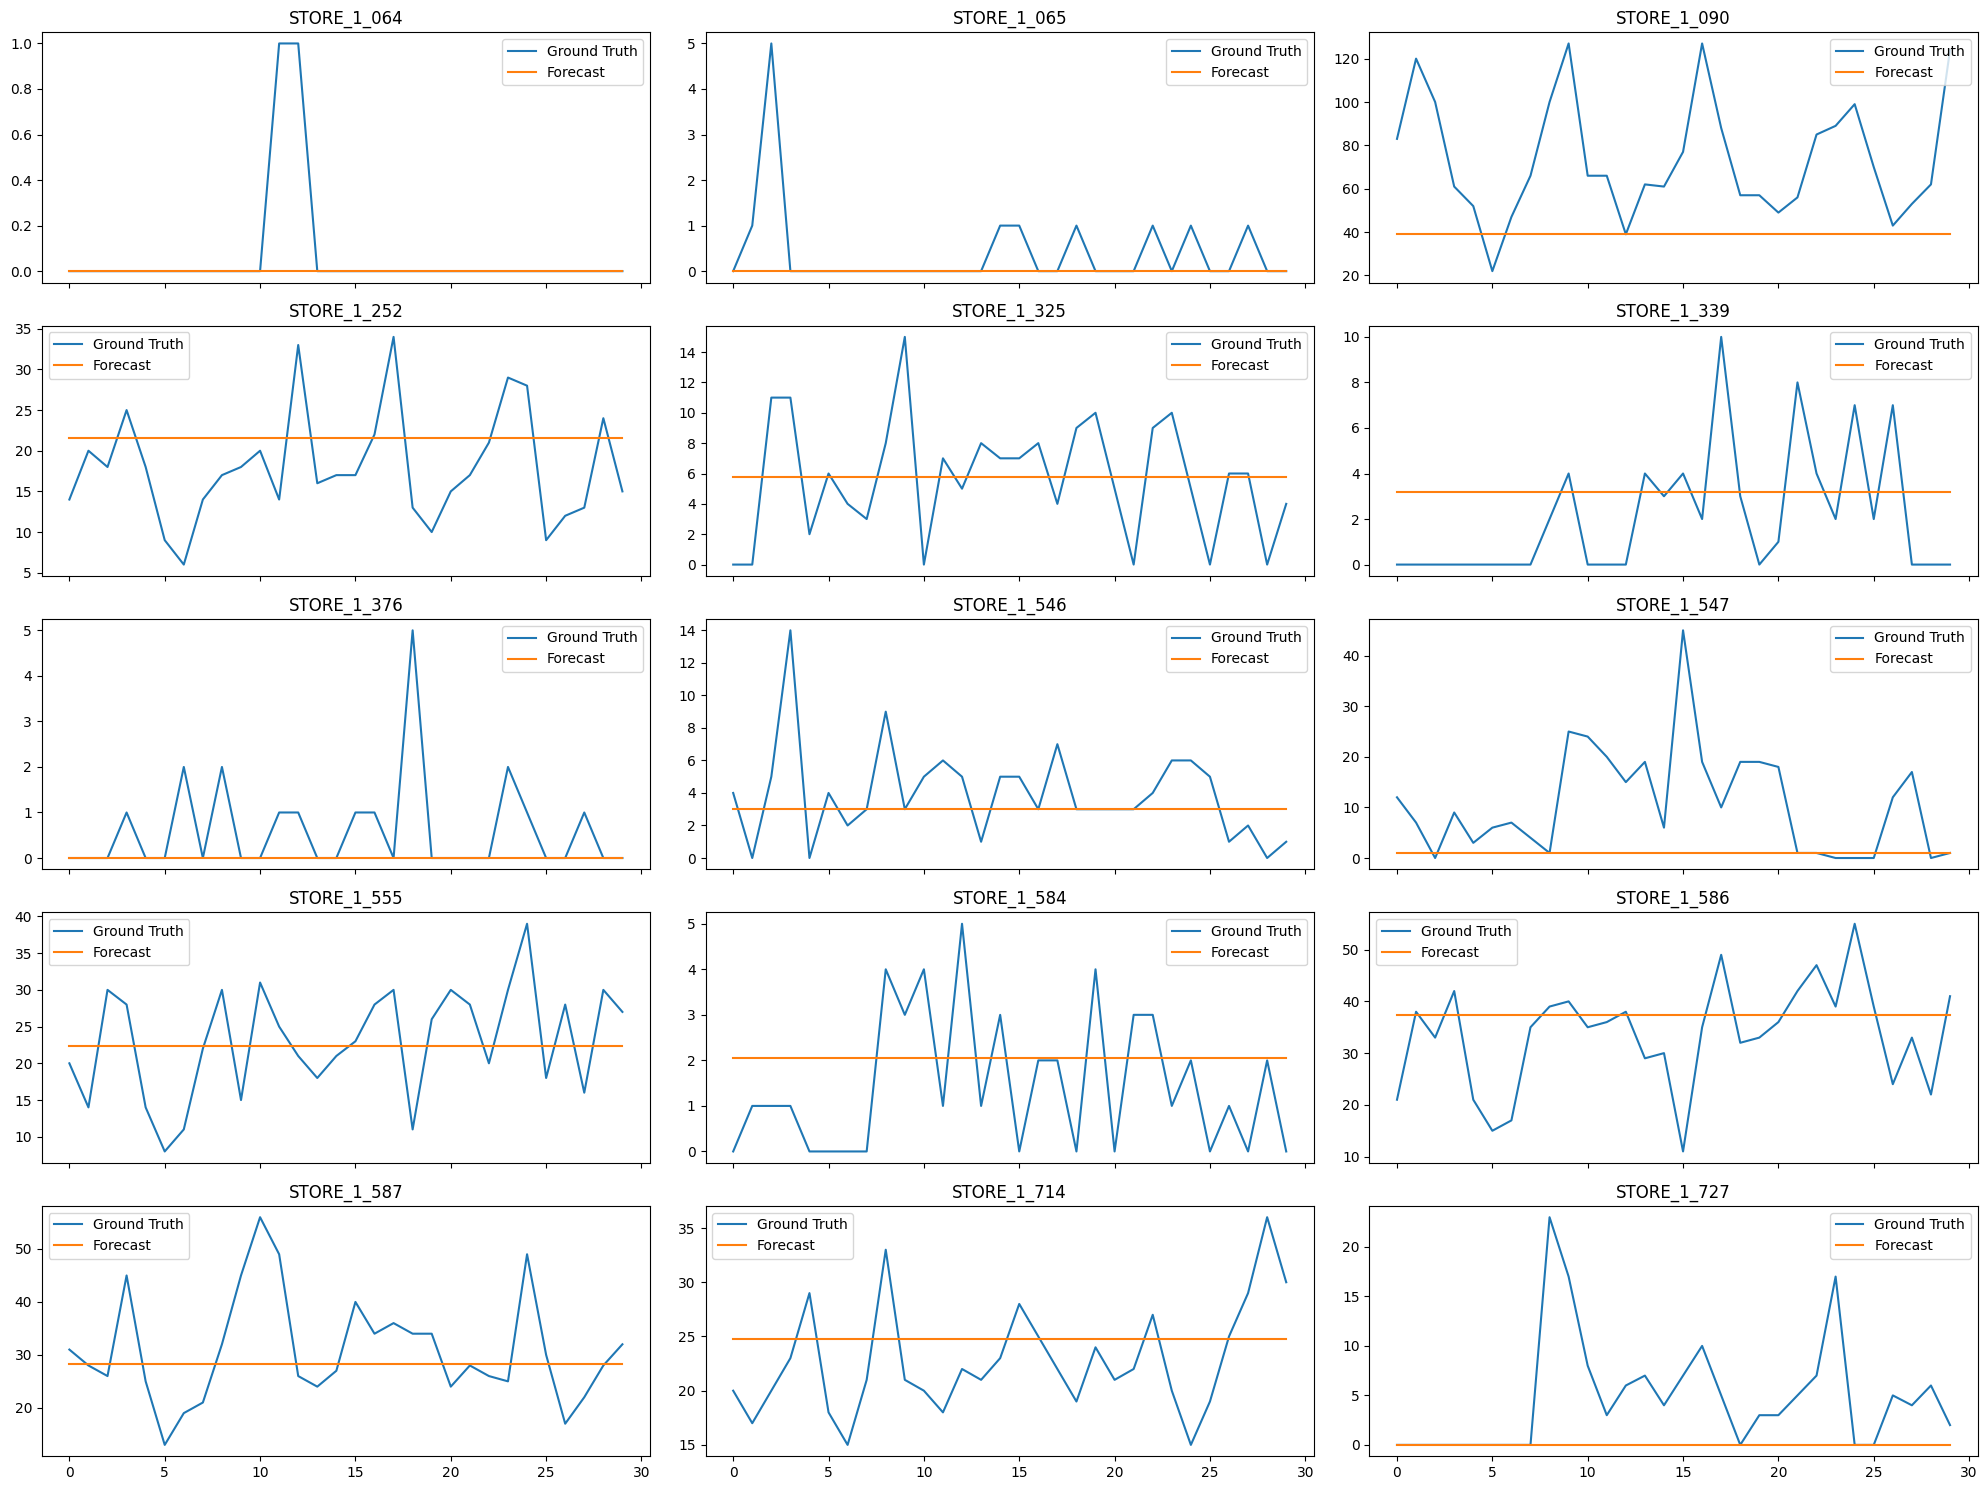



                                             Results for horizon 120 days:                                             


best_params        MAE     SMAPE        R2
STORE_1_064     window_length=1      0.175  0.283333 -0.134492
STORE_1_065     window_length=1   0.583333  0.683333 -0.247225
STORE_1_090  window_length=None  35.081233  0.849868      -0.0
STORE_1_252    window_length=10   8.181667  0.486171 -0.557141
STORE_1_325  window_length=None   3.483128   0.72914 -0.000067
STORE_1_339  window_length=None   2.256279   0.85842 -0.000111
STORE_1_376     window_length=1        0.5  0.533333 -0.223881
STORE_1_546  window_length=None   1.982763  0.741533 -0.302045
STORE_1_547  window_length=None   9.418265  0.882341 -0.035861
STORE_1_555    window_length=10   6.496667  0.294415 -0.017354
STORE_1_584    window_length=10   1.313333  1.080136 -0.022966
STORE_1_586    window_length=10   9.543333  0.301399 -0.172495
STORE_1_587     window_length=1        7.6  0.256703 -0.128281
STORE_1_714     window_length=5   6.241667  0.305328 -0.245112
STORE_1_727  window_length=None    2.89379  0.849858 -0.027761
AVERAGE                           6.383364  0.609021 -0.140986

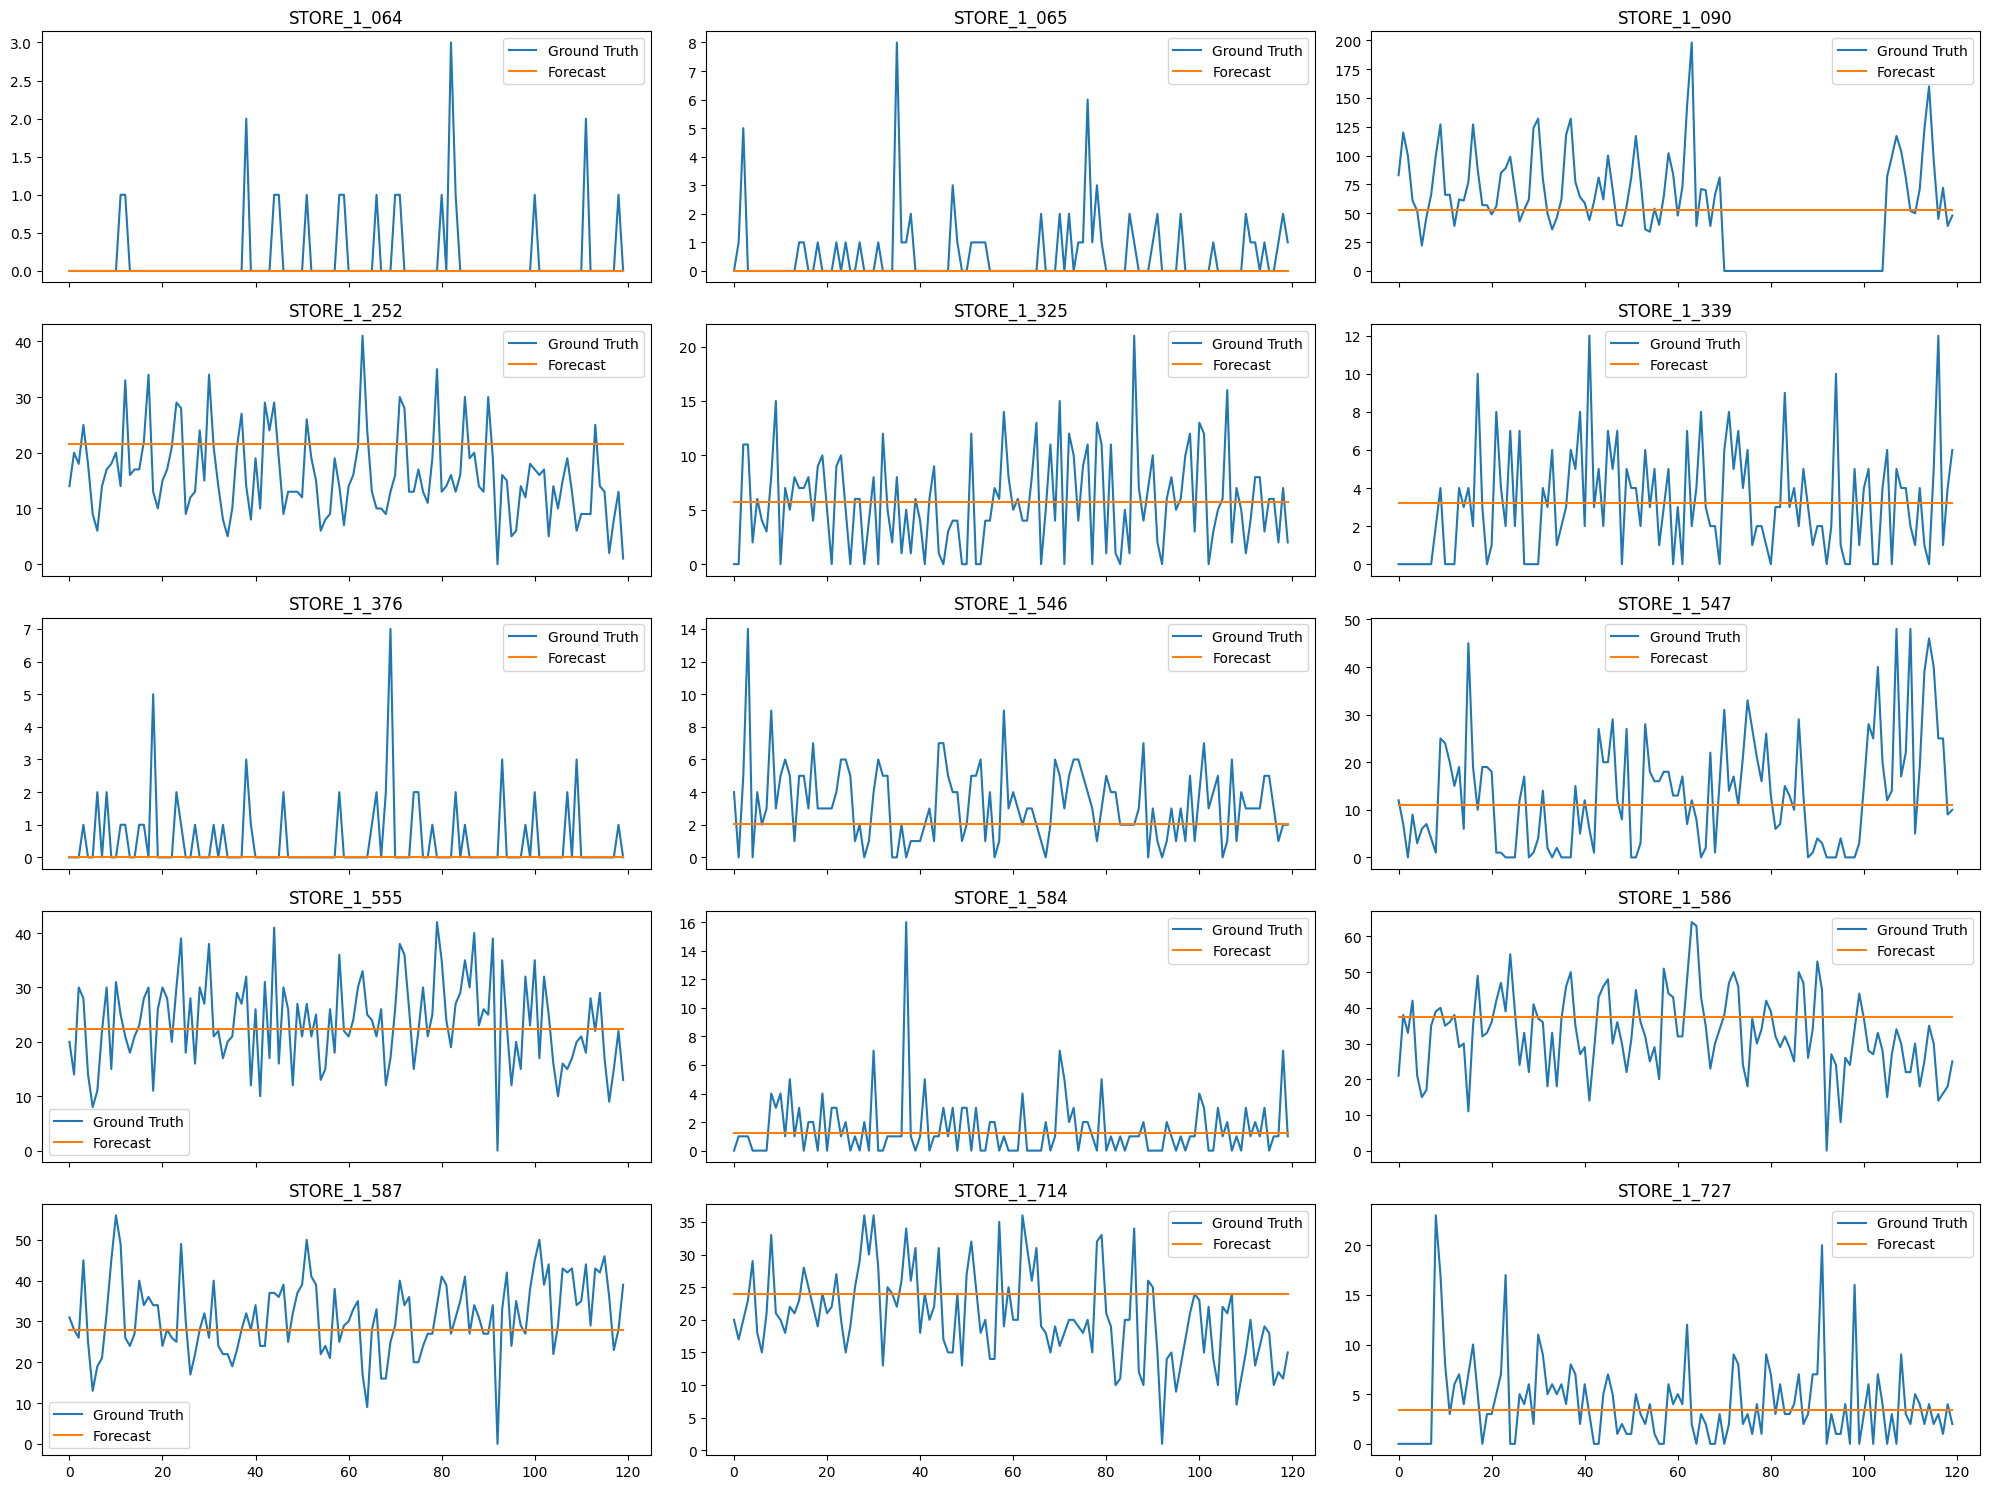

In [ ]:
for fh in FORECAST_HORIZONS:
    print("=" * 119)
    print(f"{'Results for horizon ' + str(fh) + ' days:':^119}")
    all_items_evaluation_report(results[fh])
    print("=" * 119)
    print("\n")

Данная модель даёт простое предсказание средним из последнего окна. Хороший бейзлайн.

## Naive: drift

In [ ]:
forecaster = NaiveForecaster(strategy="drift")
param_grid = {}

for fh in tqdm(FORECAST_HORIZONS, desc="Horizons", leave=False):
    for item_id in tqdm(ITEM_IDS, desc="Items", leave=False):
        cross_validate(forecaster, param_grid, fh, item_id, model_name="naive_drift")
clear_output()

In [ ]:
results = {}
for fh in tqdm(FORECAST_HORIZONS, desc="Horizons", leave=False):
    results[fh] = forecast_and_evaluate(fh, model_name="naive_drift", params=[])
clear_output()

                                              Results for horizon 7 days:                                              


best_params        MAE     SMAPE         R2
STORE_1_064                    0.0       0.0        1.0
STORE_1_065               0.857143  0.571429  -0.246575
STORE_1_090              35.606898  0.595006  -0.974176
STORE_1_252                7.92769  0.465995  -1.491685
STORE_1_325               3.858319  0.965767  -0.000412
STORE_1_339                    0.0       0.0        1.0
STORE_1_376               0.434058       2.0   -0.35952
STORE_1_546               3.142857  0.967881  -0.069162
STORE_1_547                5.57574  1.533977  -2.143086
STORE_1_555               6.861846  0.391676  -0.012391
STORE_1_584               1.582403  1.430135 -10.234382
STORE_1_586              10.007839  0.373786  -0.187346
STORE_1_587               7.098765  0.270401  -0.032523
STORE_1_714               3.284539  0.158529  -0.092893
STORE_1_727               0.010974       2.0        0.0
AVERAGE                   5.749938  0.781639  -0.922943

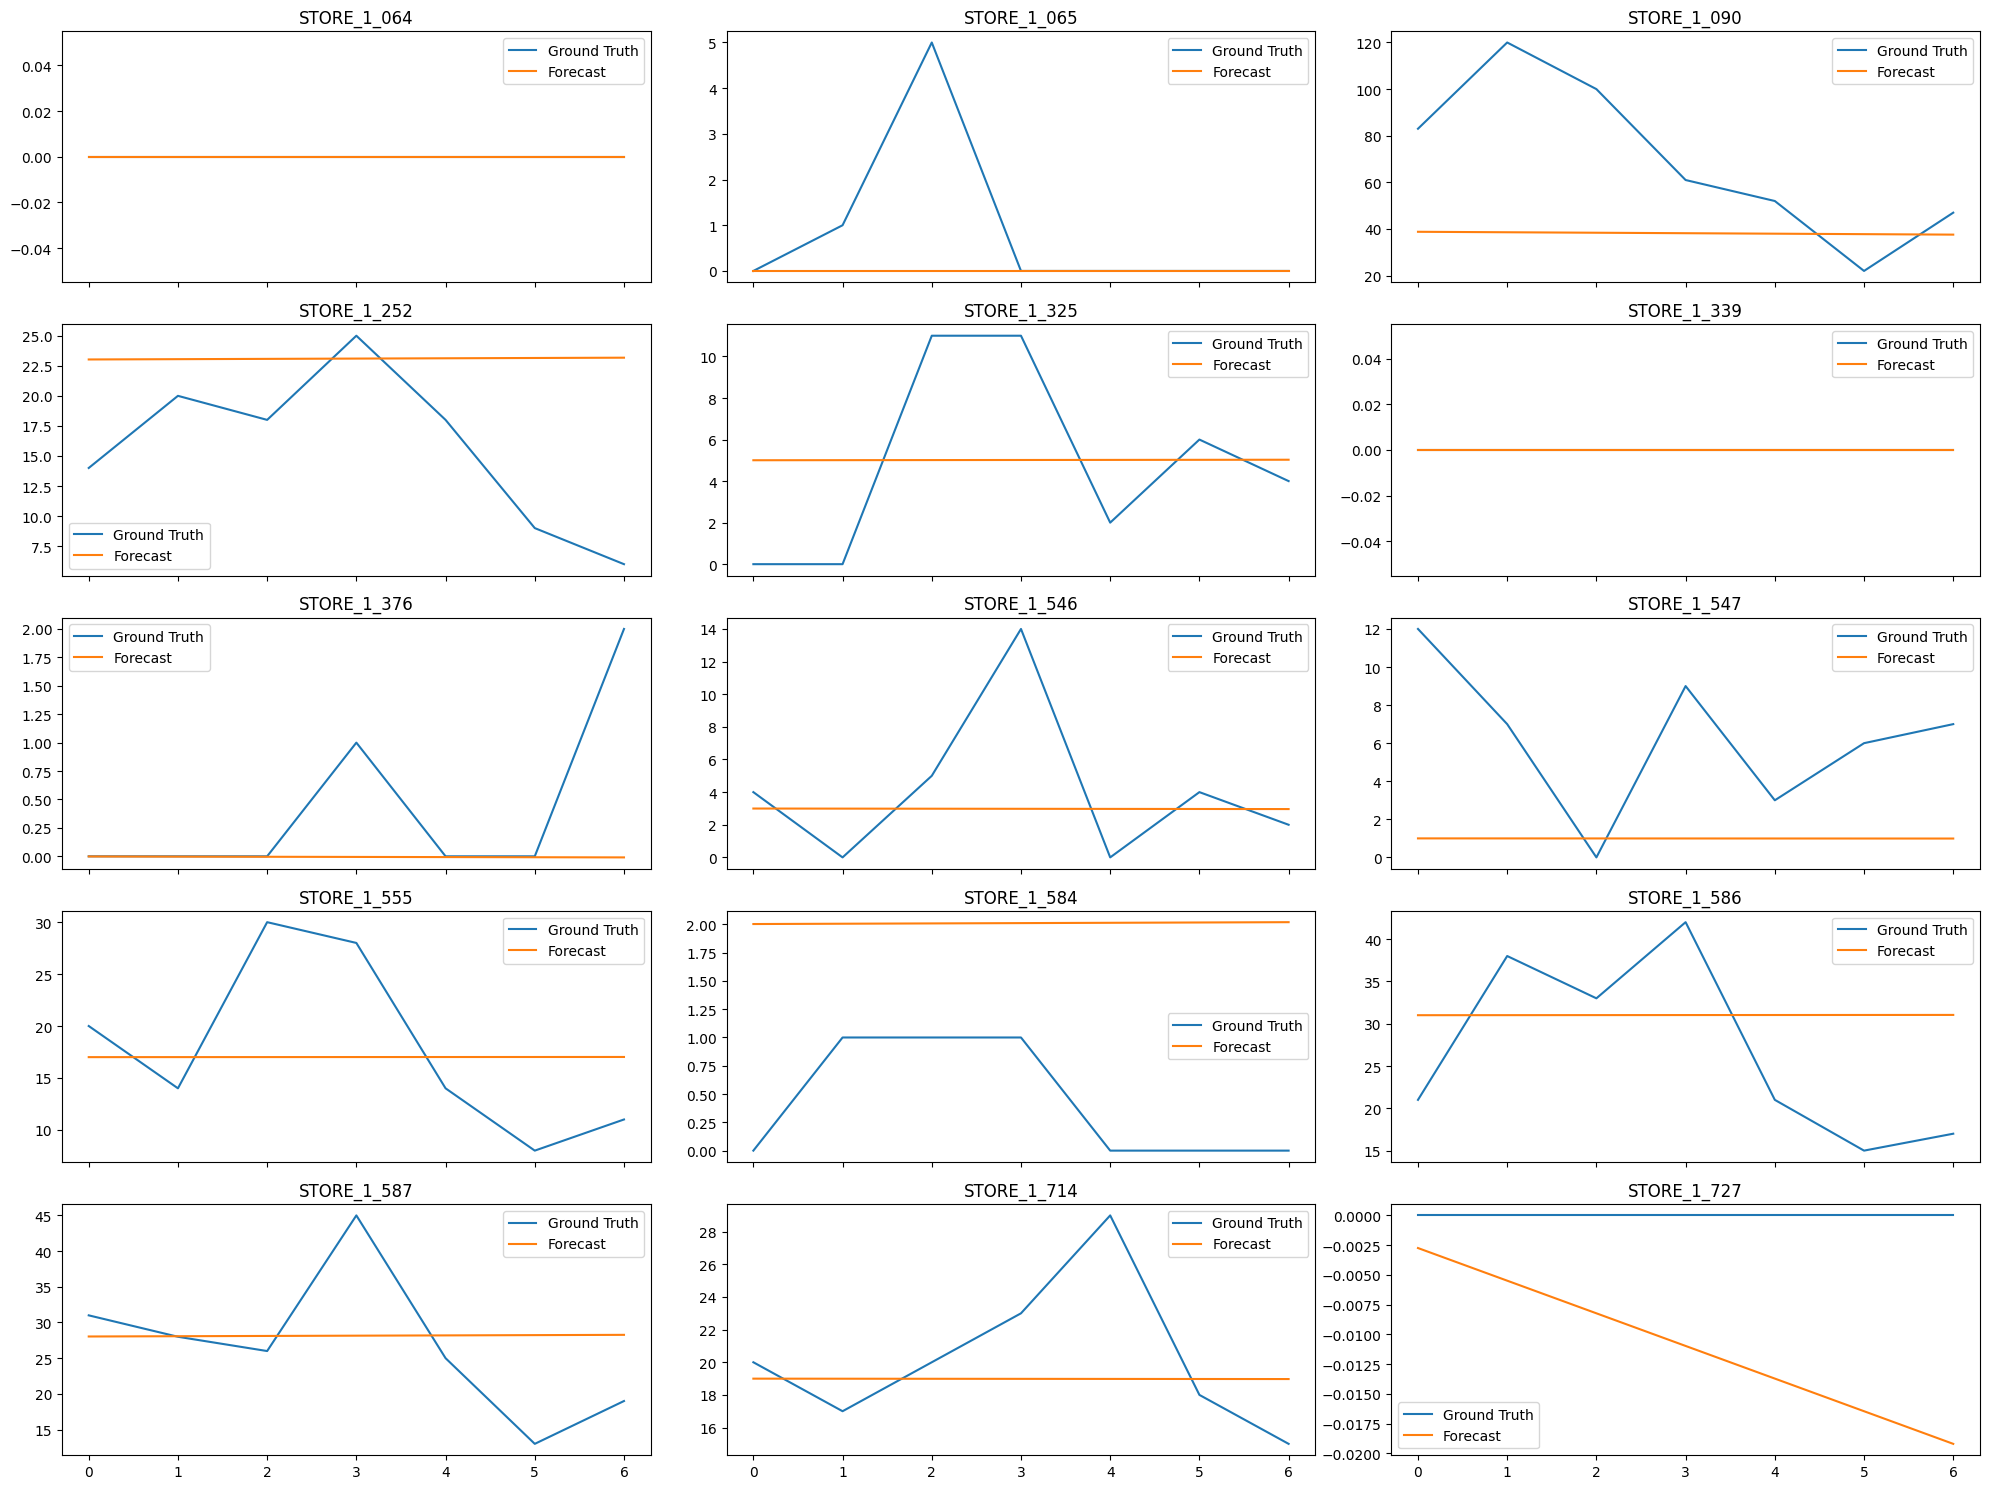



                                             Results for horizon 30 days:                                              


best_params        MAE     SMAPE        R2
STORE_1_064               0.066667  0.133333 -0.071429
STORE_1_065                    0.4  0.533333 -0.176471
STORE_1_090              38.798903  0.645354 -1.967864
STORE_1_252               7.596708  0.399409 -0.655974
STORE_1_325               3.196022   0.72809 -0.025378
STORE_1_339                    2.1       1.0 -0.578487
STORE_1_376               0.621262       2.0 -0.349801
STORE_1_546               2.099771  0.638342 -0.121294
STORE_1_547              10.011477  1.493985 -0.890084
STORE_1_555               8.038226  0.380555 -0.674865
STORE_1_584               1.420027  1.039762 -0.146324
STORE_1_586               8.458848  0.272659 -0.059602
STORE_1_587               7.503795  0.242457 -0.057058
STORE_1_714               4.616187  0.204637  -0.60039
STORE_1_727               4.775857       2.0 -0.716972
AVERAGE                   6.646917  0.780795   -0.4728

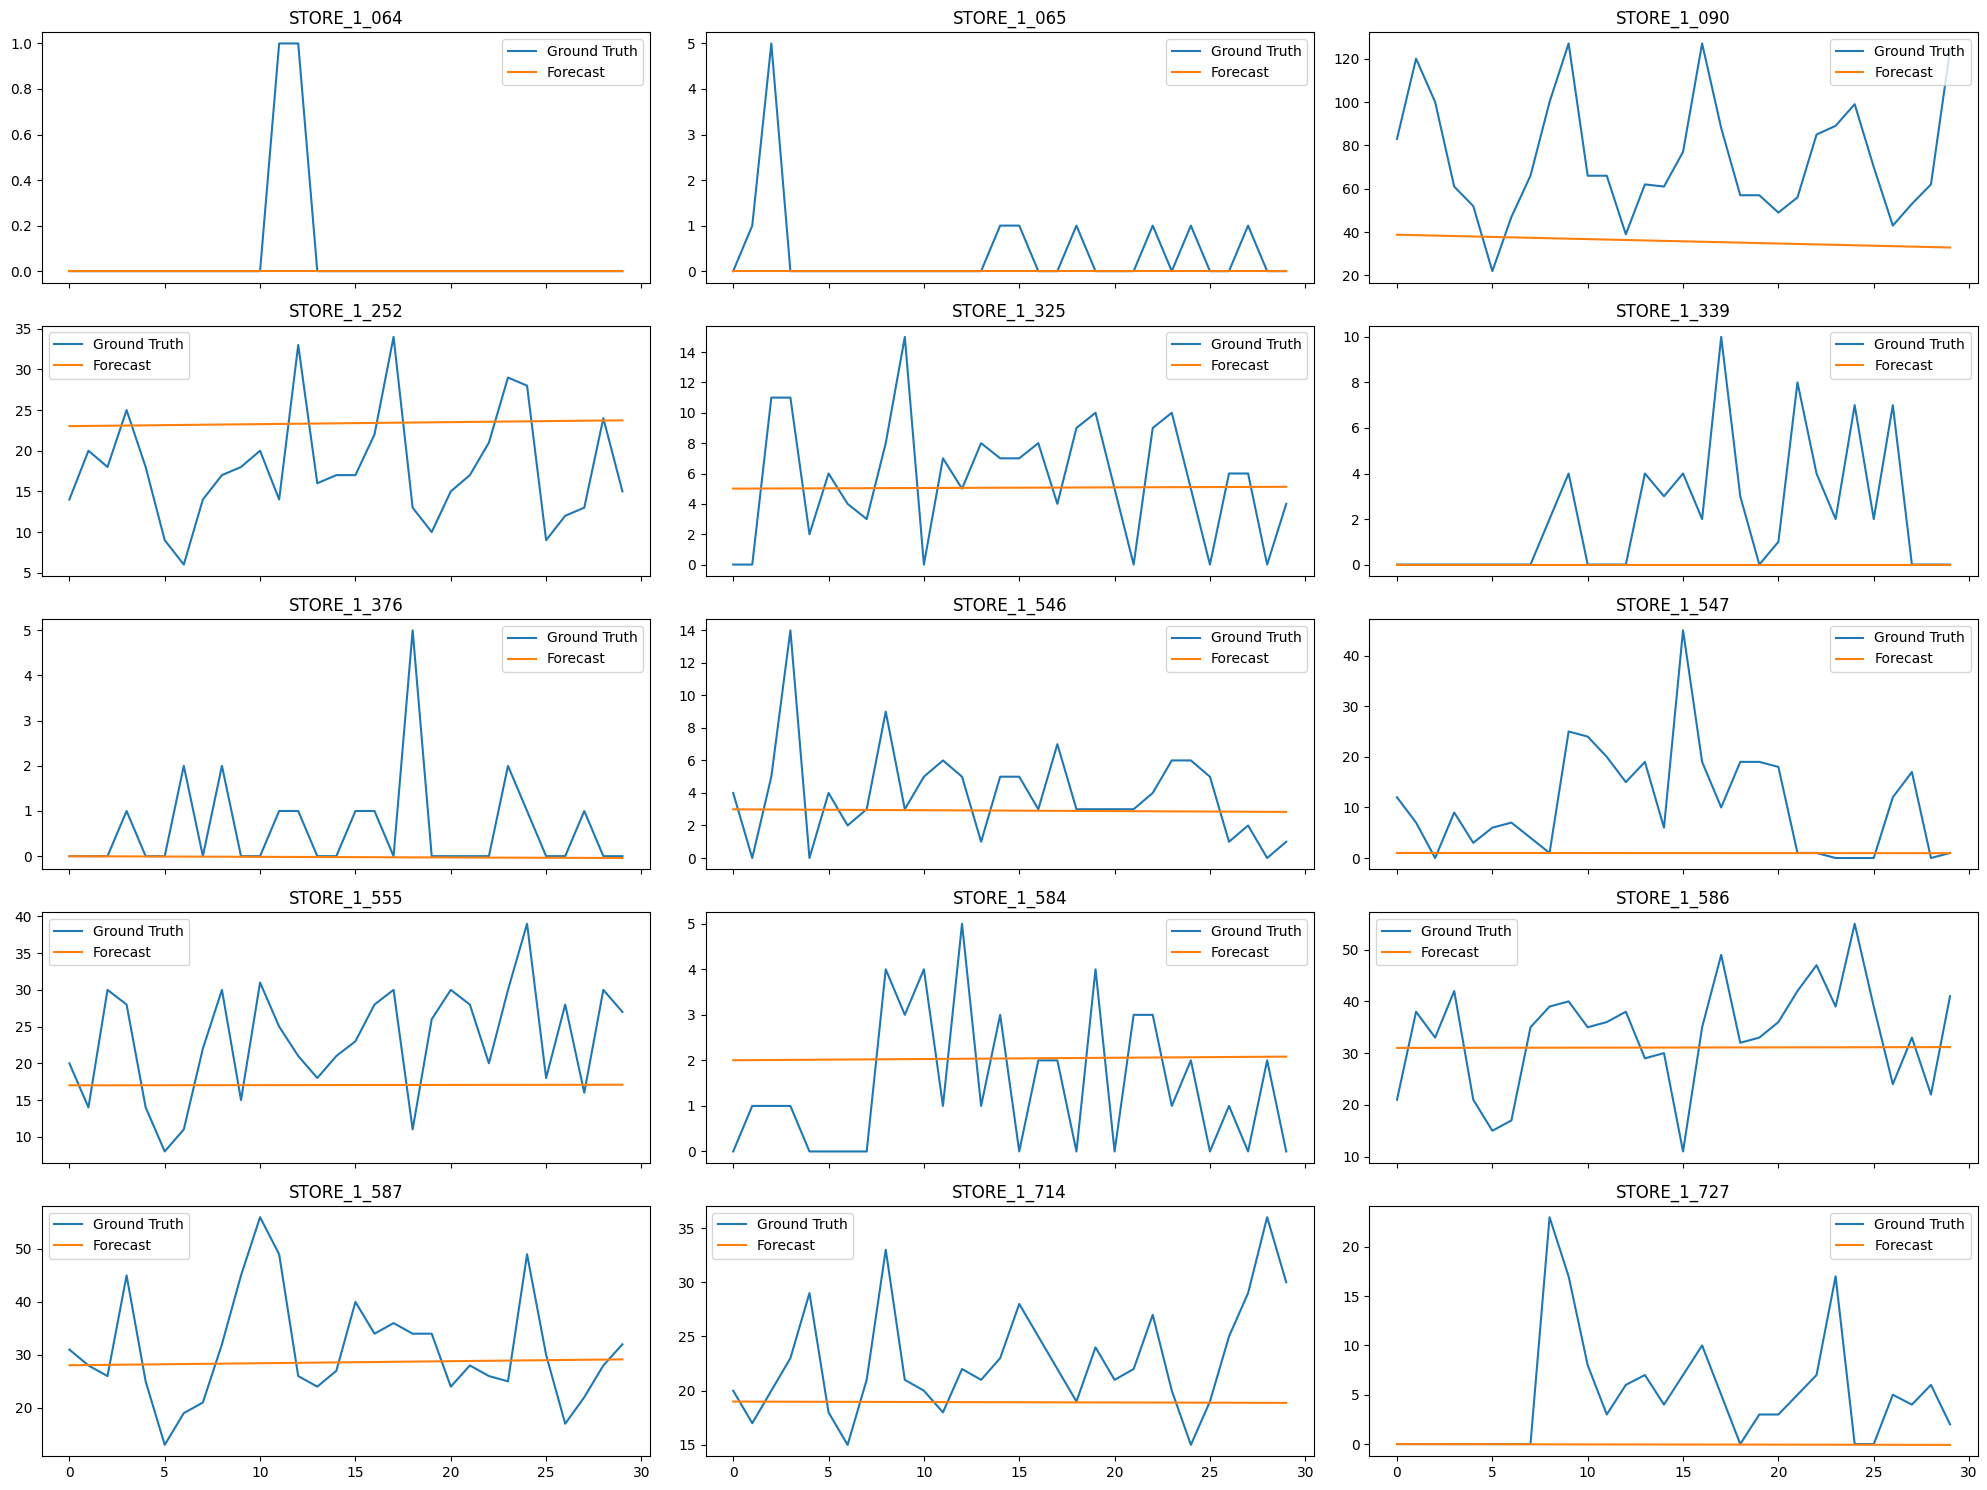



                                             Results for horizon 120 days:                                             


best_params        MAE     SMAPE        R2
STORE_1_064                  0.175  0.283333 -0.134492
STORE_1_065               0.583333  0.683333 -0.247225
STORE_1_090              39.007362  1.159947 -0.281405
STORE_1_252              10.211214  0.559794 -1.346111
STORE_1_325               3.461968  0.741744 -0.007504
STORE_1_339               3.158333  1.533333 -1.287117
STORE_1_376                0.58299       2.0 -0.302418
STORE_1_546               1.811991  0.655606 -0.055628
STORE_1_547              12.683162  1.631367 -1.111996
STORE_1_555                8.21118  0.382796 -0.622579
STORE_1_584               1.664289  1.088191 -0.103517
STORE_1_586               8.730658  0.283641 -0.024658
STORE_1_587               7.198331  0.242455  0.016616
STORE_1_714               5.358471  0.271617 -0.061738
STORE_1_727               4.265981       2.0 -1.047715
AVERAGE                   7.140284  0.901144 -0.441166

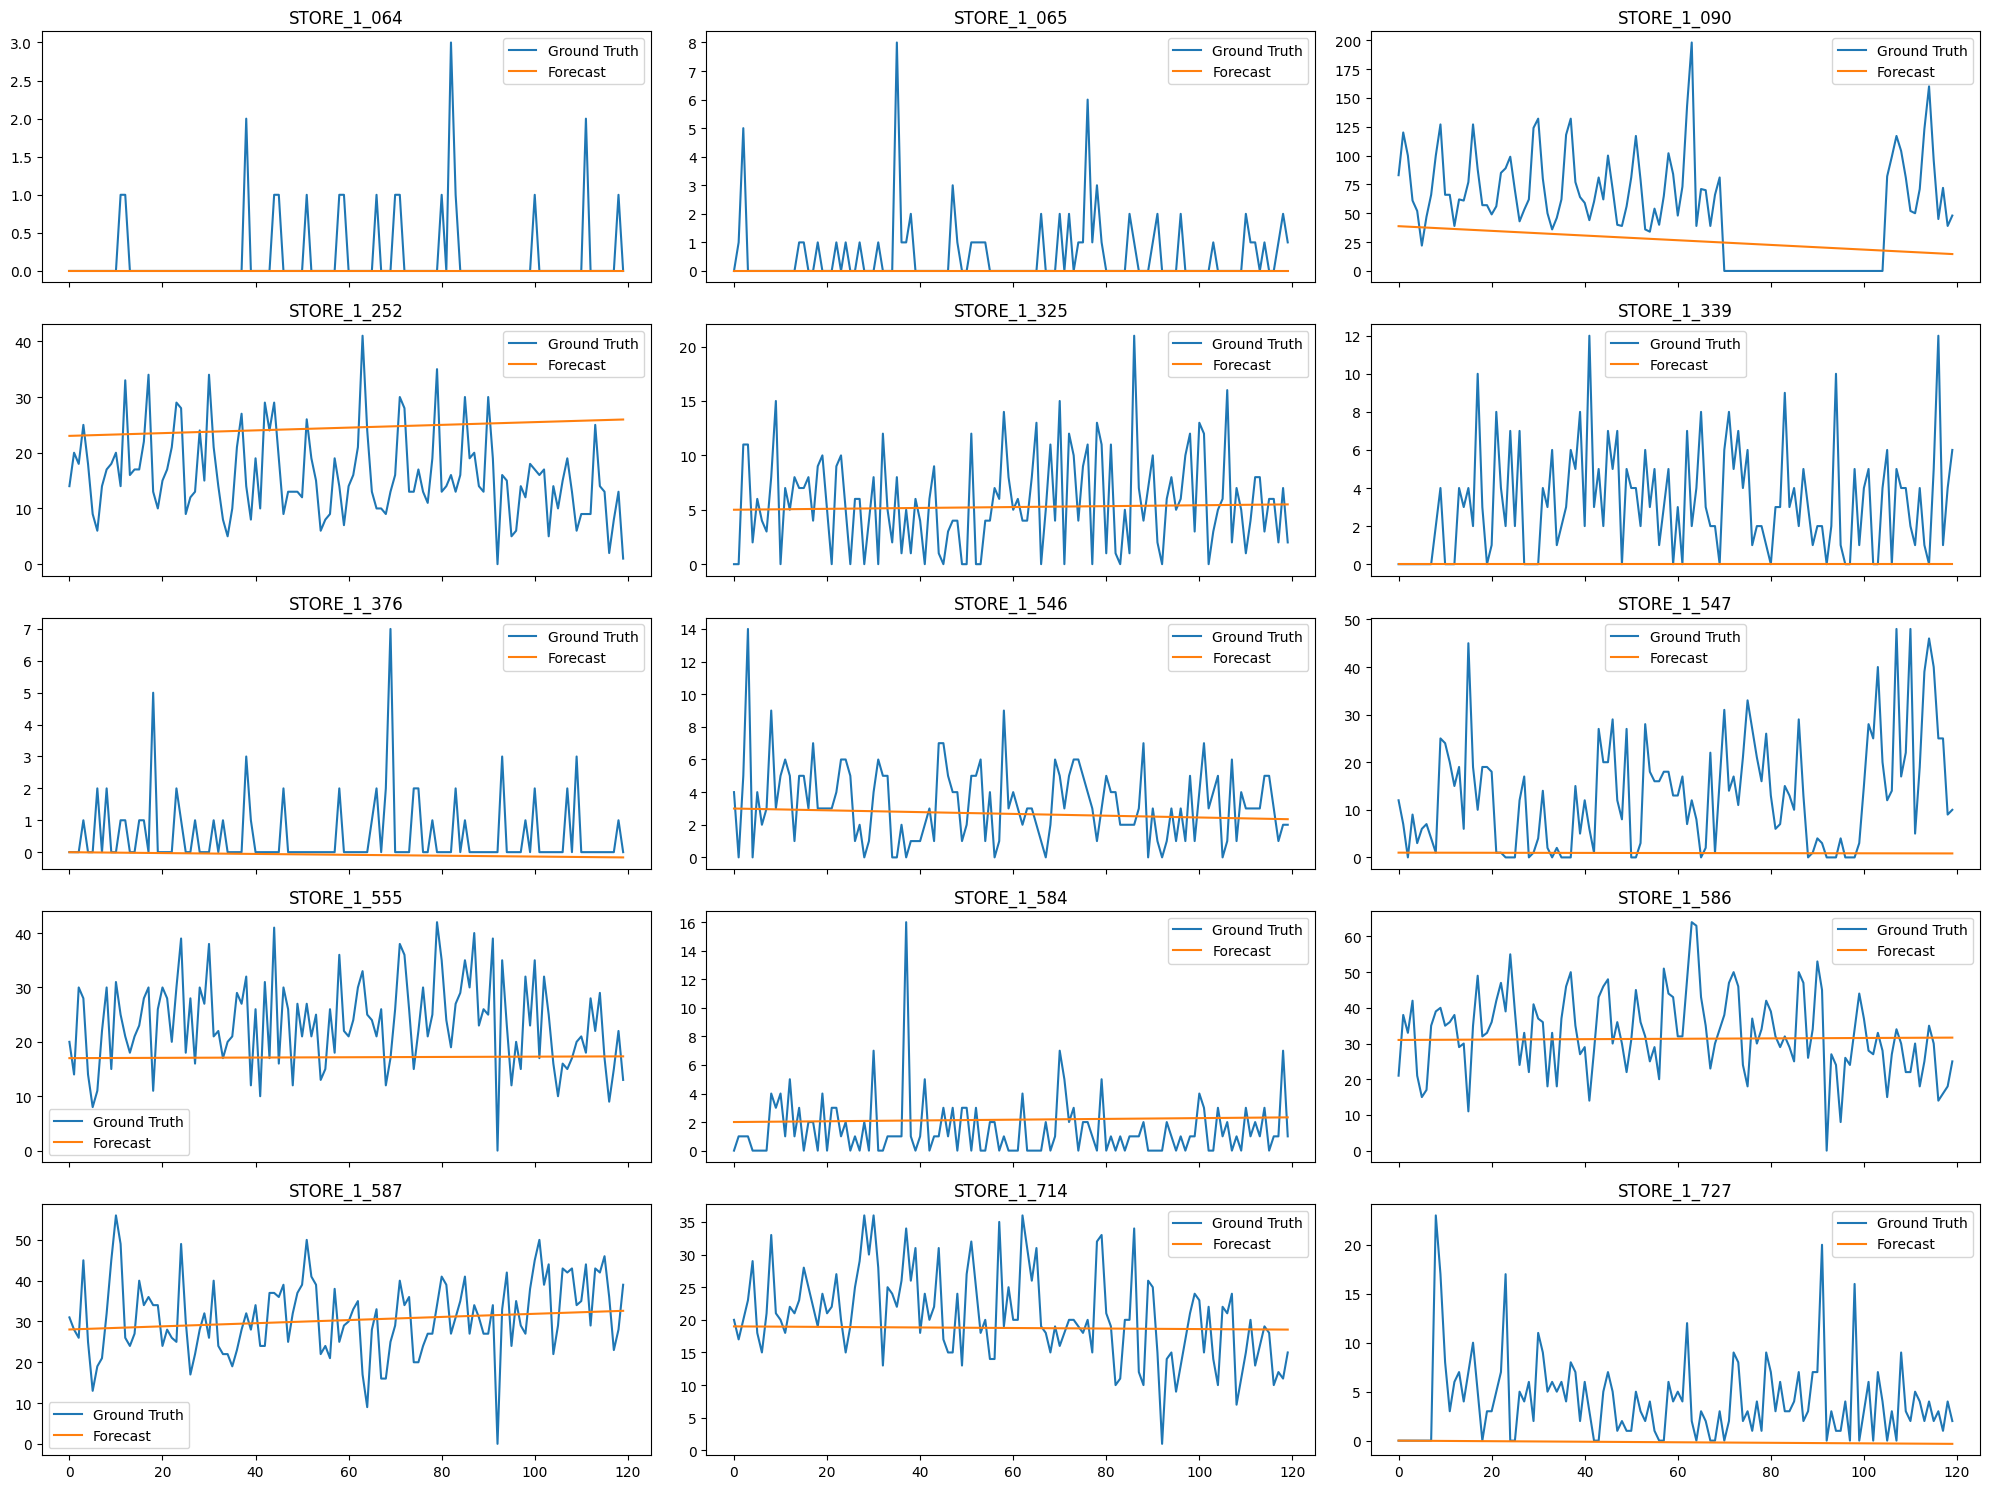

In [ ]:
for fh in FORECAST_HORIZONS:
    print("=" * 119)
    print(f"{'Results for horizon ' + str(fh) + ' days:':^119}")
    all_items_evaluation_report(results[fh])
    print("=" * 119)
    print("\n")

Данная модель строит линейный тренд и предсказывает простой экстраполяцией его в будущее.

## Сравнение наивных моделей

Провизуализируем прогнозы 3-х наивных моделей на ВР случайного товара для всех горизонтов прогнозирования (7, 30, 120 дней).

In [ ]:
item_id = ITEM_IDS[np.random.choice(len(ITEM_IDS))]
print(item_id)

STORE_1_090


                                       Results for STORE_1_090 (horizon=7 days):                                       


best_params        MAE     SMAPE        R2
model                                                      
naive_last              sp=1  35.142857  0.583859 -0.943726
naive_mean   window_length=3  27.285714  0.421807 -0.307429
naive_drift                   35.606898  0.595006 -0.974176

Items:   0%|          | 0/15 [00:00<?, ?it/s]

Items:   0%|          | 0/15 [00:00<?, ?it/s]

Items:   0%|          | 0/15 [00:00<?, ?it/s]

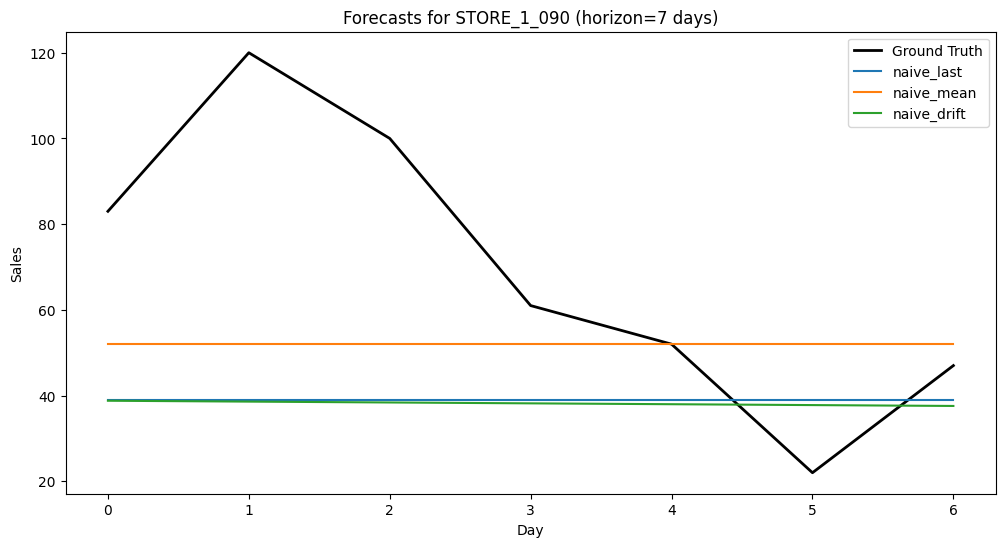


                                      Results for STORE_1_090 (horizon=30 days):                                       


best_params        MAE     SMAPE        R2
model                                                      
naive_last              sp=1  35.733333  0.571578 -1.651772
naive_mean   window_length=1  35.733333  0.571578 -1.651772
naive_drift                   38.798903  0.645354 -1.967864

Items:   0%|          | 0/15 [00:00<?, ?it/s]

Items:   0%|          | 0/15 [00:00<?, ?it/s]

Items:   0%|          | 0/15 [00:00<?, ?it/s]

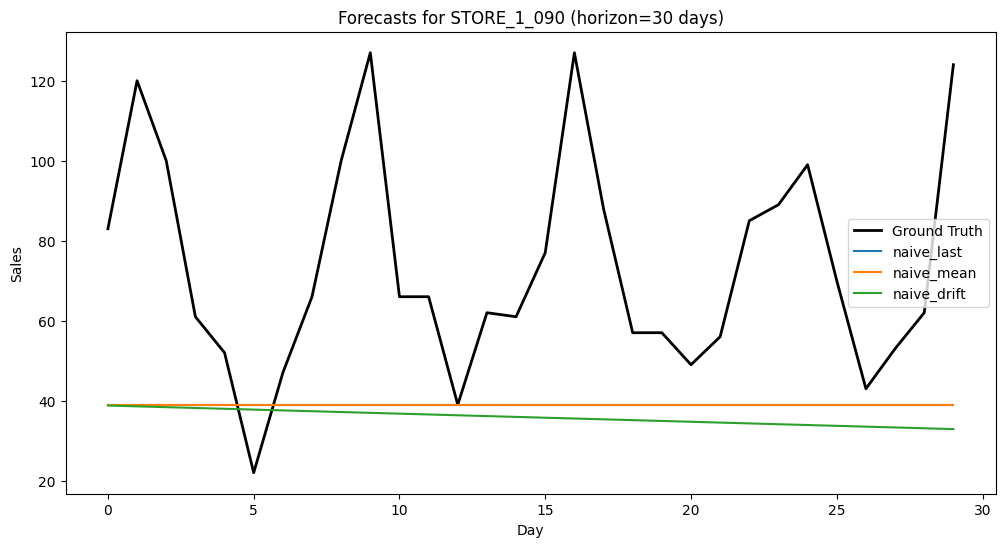


                                      Results for STORE_1_090 (horizon=120 days):                                      


best_params        MAE     SMAPE            R2
model                                                             
naive_last               sp=365  23.758333  0.382546  3.362687e-01
naive_mean   window_length=None  35.081233  0.849868 -2.830506e-08
naive_drift                      39.007362  1.159947 -2.814048e-01

Items:   0%|          | 0/15 [00:00<?, ?it/s]

Items:   0%|          | 0/15 [00:00<?, ?it/s]

Items:   0%|          | 0/15 [00:00<?, ?it/s]

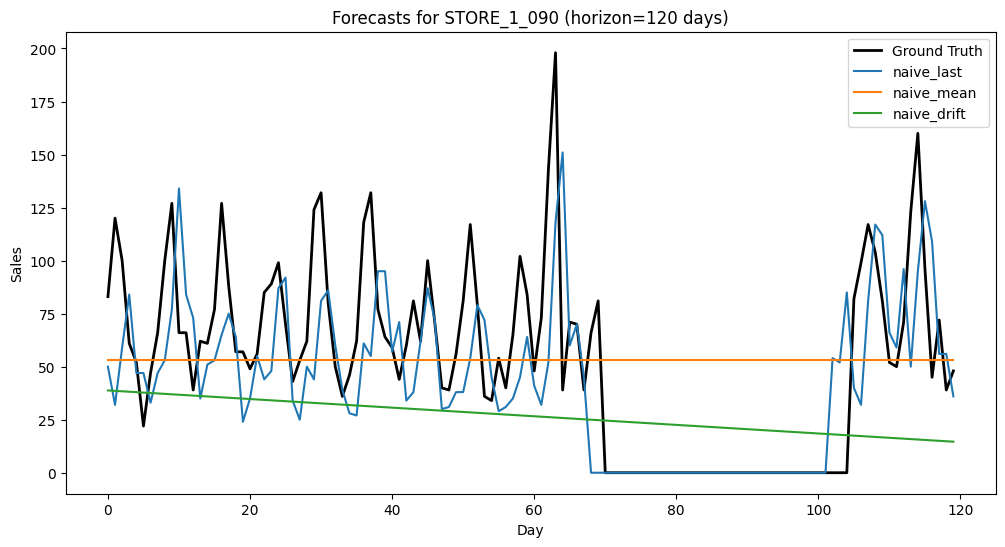

In [ ]:
models = ["naive_last", "naive_mean", "naive_drift"]
one_item_multiple_models_evaluation_report(item_id, models, FORECAST_HORIZONS)

Сравним аггрегированные метрики предсказаний по всем товарам наивных моделей.

In [ ]:
avg_metrics_multiple_models_report(models, FORECAST_HORIZONS)

Forecast horizon: 7 days


MAE     SMAPE        R2
model                                    
naive_last   6.009524  0.494859 -1.380266
naive_mean   5.515956  0.559697 -0.945080
naive_drift  5.749938  0.781639 -0.922943


Forecast horizon: 30 days


MAE     SMAPE        R2
model                                    
naive_last   6.824444  0.712066 -0.856255
naive_mean   6.240895  0.644630 -0.328416
naive_drift  6.646917  0.780795 -0.472800


Forecast horizon: 120 days


MAE     SMAPE        R2
model                                    
naive_last   6.550000  0.749367 -0.854109
naive_mean   6.383364  0.609021 -0.140986
naive_drift  7.140284  0.901144 -0.441166

Предсказание средним работает ненамного лучше всех.

# Классические статистические модели

## SARIMA

Модель SARIMA может учитывать сезонность, тренд. То есть эту модель можно применять в нестационарным рядам (в отличии от простой ARMA).  
В качестве бейзлайна классической статистической модели - хорошо подойдёт.  

Подбирать гиперпараметры (p, q, d, P, Q, D) будем следующим способом:
   1. Графический анализ ряда
   2. Стабилизация дисперсии при необходимости
   3. Подбор порядка дифференцирования, при котором ряд становится стационарным. Таким образом фиксируются параметры d; D модели ARIMA.
   4. Построить графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF) и из этих графиков определить примерные значения параметров p; q; P; Q.
   5. Полученные модели обучаем на кросс-валидации и выбираем лучшую.
Пункты 1-4 были проделаны для каждого ВР в [eda.ipynb](report_1__eda.ipynb).

Из минусов модели можно отметить то, что подать дополнительные фичи не получится (а у нас они есть) - но это мы сделаем в модели SARIMAX.

In [ ]:
# Определим по ACF и PACF (построенным при EDA) гипер-параметры модели SARIMA для ВР каждого товара
item_id_2_sarima_params = {
    "STORE_1_064": {
        "max_p": 5,
        "max_P": 7,
        "max_q": 1,
        "max_Q": 0,
        "d": 1,
        "D": 1,
        "seasonal_period": 7,
    },
    "STORE_1_065": {
        "max_p": 6,
        "max_P": 7,
        "max_q": 1,
        "max_Q": 0,
        "d": 1,
        "D": 1,
        "seasonal_period": 7,
    },
    "STORE_1_325": {
        "max_p": 5,
        "max_P": 7,
        "max_q": 1,
        "max_Q": 0,
        "d": 1,
        "D": 1,
        "seasonal_period": 7,
    },
    "STORE_1_376": {
        "max_p": 5,
        "max_P": 7,
        "max_q": 1,
        "max_Q": 0,
        "d": 1,
        "D": 1,
        "seasonal_period": 7,
    },
    "STORE_1_090": {
        "max_p": 3,
        "max_P": 0,
        "max_q": 2,
        "max_Q": 0,
        "d": 1,
        "D": 1,
        "seasonal_period": 7,
    },
    "STORE_1_252": {
        "max_p": 6,
        "max_P": 0,
        "max_q": 1,
        "max_Q": 7,
        "d": 1,
        "D": 1,
        "seasonal_period": 7,
    },
    "STORE_1_339": {
        "max_p": 1,
        "max_P": 7,
        "max_q": 1,
        "max_Q": 7,
        "d": 1,
        "D": 1,
        "seasonal_period": 7,
    },
    "STORE_1_546": {
        "max_p": 6,
        "max_P": 0,
        "max_q": 1,
        "max_Q": 0,
        "d": 1,
        "D": 1,
        "seasonal_period": 7,
    },
    "STORE_1_547": {
        "max_p": 5,
        "max_P": 0,
        "max_q": 1,
        "max_Q": 0,
        "d": 1,
        "D": 1,
        "seasonal_period": 7,
    },
    "STORE_1_555": {
        "max_p": 6,
        "max_P": 0,
        "max_q": 1,
        "max_Q": 7,
        "d": 1,
        "D": 1,
        "seasonal_period": 7,
    },
    "STORE_1_584": {
        "max_p": 6,
        "max_P": 0,
        "max_q": 1,
        "max_Q": 0,
        "d": 1,
        "D": 1,
        "seasonal_period": 7,
    },
    "STORE_1_586": {
        "max_p": 6,
        "max_P": 0,
        "max_q": 3,
        "max_Q": 7,
        "d": 1,
        "D": 1,
        "seasonal_period": 7,
    },
    "STORE_1_587": {
        "max_p": 3,
        "max_P": 7,
        "max_q": 1,
        "max_Q": 7,
        "d": 1,
        "D": 1,
        "seasonal_period": 7,
    },
    "STORE_1_714": {
        "max_p": 6,
        "max_P": 0,
        "max_q": 1,
        "max_Q": 7,
        "d": 1,
        "D": 1,
        "seasonal_period": 7,
    },
    "STORE_1_727": {
        "max_p": 6,
        "max_P": 0,
        "max_q": 1,
        "max_Q": 7,
        "d": 1,
        "D": 1,
        "seasonal_period": 7,
    },
}


def sarima_params_2_param_grid(sarima_params: dict) -> dict:
    return {
        "order": [
            (p, sarima_params["d"], q)
            for p in range(sarima_params["max_p"] + 1)
            for q in range(sarima_params["max_q"] + 1)
        ],
        "seasonal_order": [
            (P, sarima_params["D"], Q, sarima_params["seasonal_period"])
            for P in range(sarima_params["max_P"] + 1)
            for Q in range(sarima_params["max_Q"] + 1)
        ],
    }

In [ ]:
for item_id in ITEM_IDS:
    params = item_id_2_sarima_params[item_id]
    num_order = (params["max_p"] + 1) * (params["max_q"] + 1)
    num_seasonal_order = (params["max_P"] + 1) * (params["max_Q"] + 1)
    total_combinations = num_order * num_seasonal_order
    print(f"{item_id}: {total_combinations} combinations")

STORE_1_064: 96 combinations
STORE_1_065: 112 combinations
STORE_1_090: 12 combinations
STORE_1_252: 112 combinations
STORE_1_325: 96 combinations
STORE_1_339: 256 combinations
STORE_1_376: 96 combinations
STORE_1_546: 14 combinations
STORE_1_547: 12 combinations
STORE_1_555: 112 combinations
STORE_1_584: 14 combinations
STORE_1_586: 224 combinations
STORE_1_587: 512 combinations
STORE_1_714: 112 combinations
STORE_1_727: 112 combinations


### Forecast horizon = 7 days

In [ ]:
for item_id in tqdm(ITEM_IDS, desc="Items", leave=False):
    param_grid = sarima_params_2_param_grid(item_id_2_sarima_params[item_id])
    cross_validate(
        forecaster=SARIMAX(), param_grid=param_grid, fh=7, item_id=item_id, model_name="sarima", use_custom_cv=True
    )

In [ ]:
results = forecast_and_evaluate(7, "sarima", ["order", "seasonal_order"])

Items:   0%|          | 0/15 [00:00<?, ?it/s]

                                             Results for horizon 30 days:                                              


best_params        MAE  \
STORE_1_064  order=(0, 1, 0), seasonal_order=(0, 1, 0, 7)    1.00554   
STORE_1_065  order=(0, 1, 0), seasonal_order=(0, 1, 0, 7)        1.0   
STORE_1_090  order=(3, 1, 2), seasonal_order=(0, 1, 0, 7)  20.137844   
STORE_1_252  order=(4, 1, 1), seasonal_order=(0, 1, 2, 7)  10.327326   
STORE_1_325  order=(4, 1, 1), seasonal_order=(6, 1, 0, 7)   3.620984   
AVERAGE                                                     7.218339   

                SMAPE        R2  
STORE_1_064       2.0       0.0  
STORE_1_065  0.872366 -0.294521  
STORE_1_090  0.333902  0.354027  
STORE_1_252  0.553284 -2.416194  
STORE_1_325  0.845774 -0.004682  
AVERAGE      0.921065 -0.472274

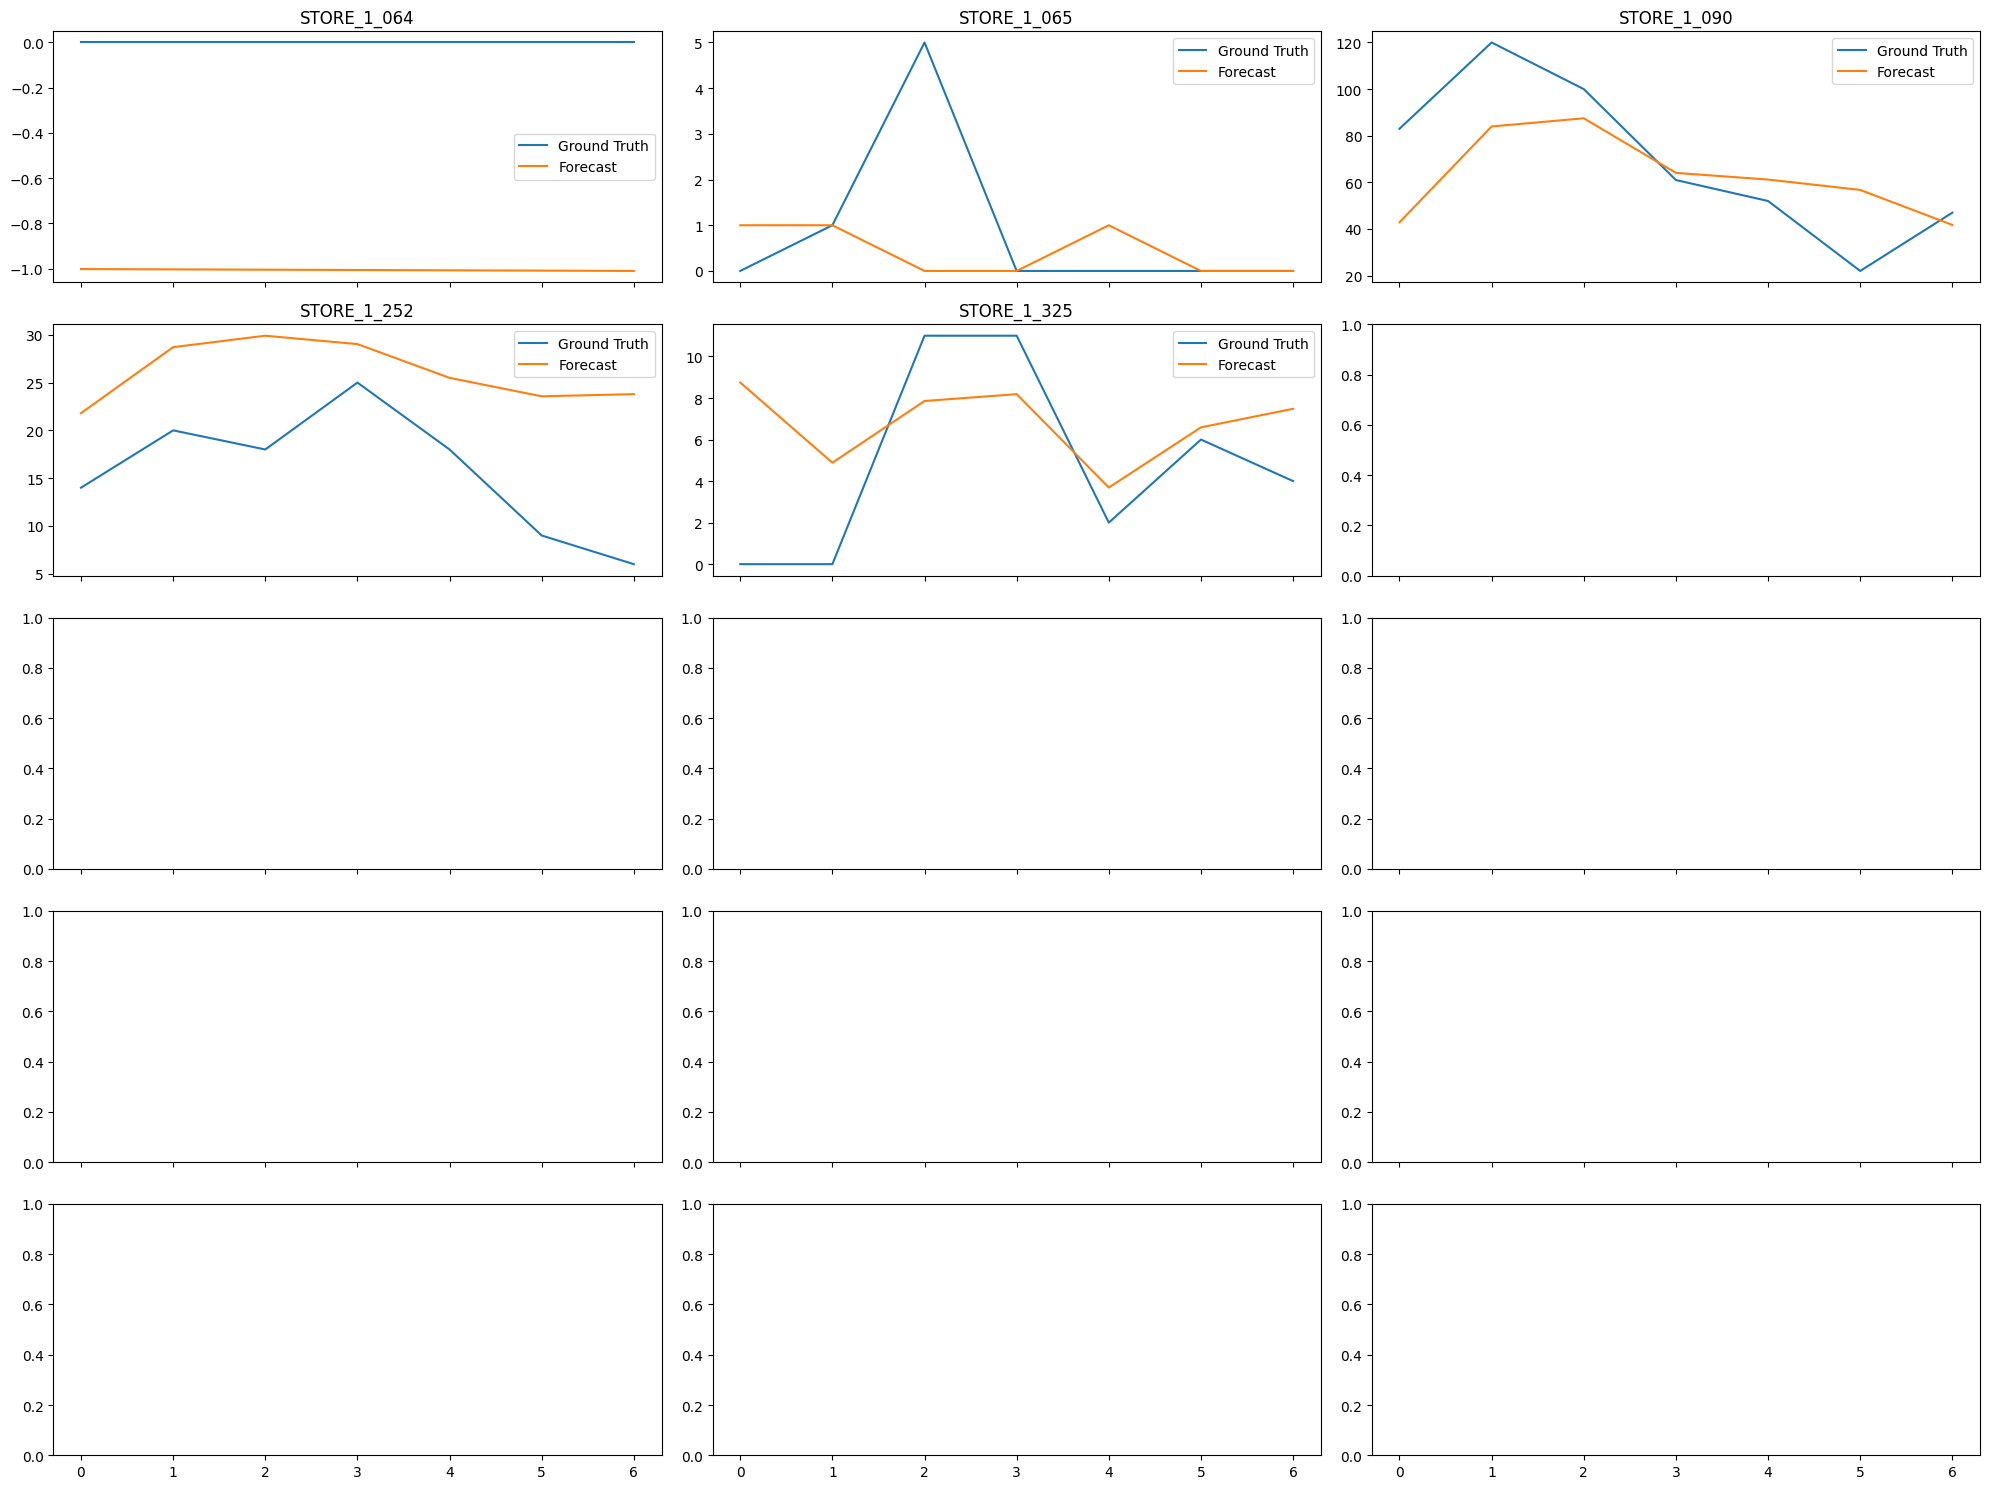

In [ ]:
print("=" * 119)
print(f"{'Results for horizon ' + str(30) + ' days:':^119}")
all_items_evaluation_report(results)
print("=" * 119)
print("\n")

### Forecast horizon = 30 days

In [ ]:
for item_id in tqdm(ITEM_IDS, desc="Items", leave=False):
    param_grid = sarima_params_2_param_grid(item_id_2_sarima_params[item_id])
    cross_validate(
        forecaster=SARIMAX(), param_grid=param_grid, fh=30, item_id=item_id, model_name="sarima", use_custom_cv=True
    )

In [ ]:
results = forecast_and_evaluate(30, "sarima", ["order", "seasonal_order"])

Items:   0%|          | 0/15 [00:00<?, ?it/s]

                                             Results for horizon 30 days:                                              


best_params        MAE  \
STORE_1_064  order=(4, 1, 0), seasonal_order=(5, 1, 0, 7)   0.312848   
STORE_1_065  order=(0, 1, 0), seasonal_order=(0, 1, 0, 7)   0.533333   
STORE_1_090  order=(1, 1, 2), seasonal_order=(0, 1, 0, 7)  15.769961   
STORE_1_252  order=(5, 1, 1), seasonal_order=(0, 1, 1, 7)   9.223086   
STORE_1_325  order=(5, 1, 1), seasonal_order=(7, 1, 0, 7)   3.341059   
AVERAGE                                                     5.836057   

                SMAPE        R2  
STORE_1_064       2.0 -1.924848  
STORE_1_065  0.816515 -0.323529  
STORE_1_090  0.231925  0.457748  
STORE_1_252  0.458889 -1.268666  
STORE_1_325  0.712115 -0.189325  
AVERAGE      0.843889 -0.649724

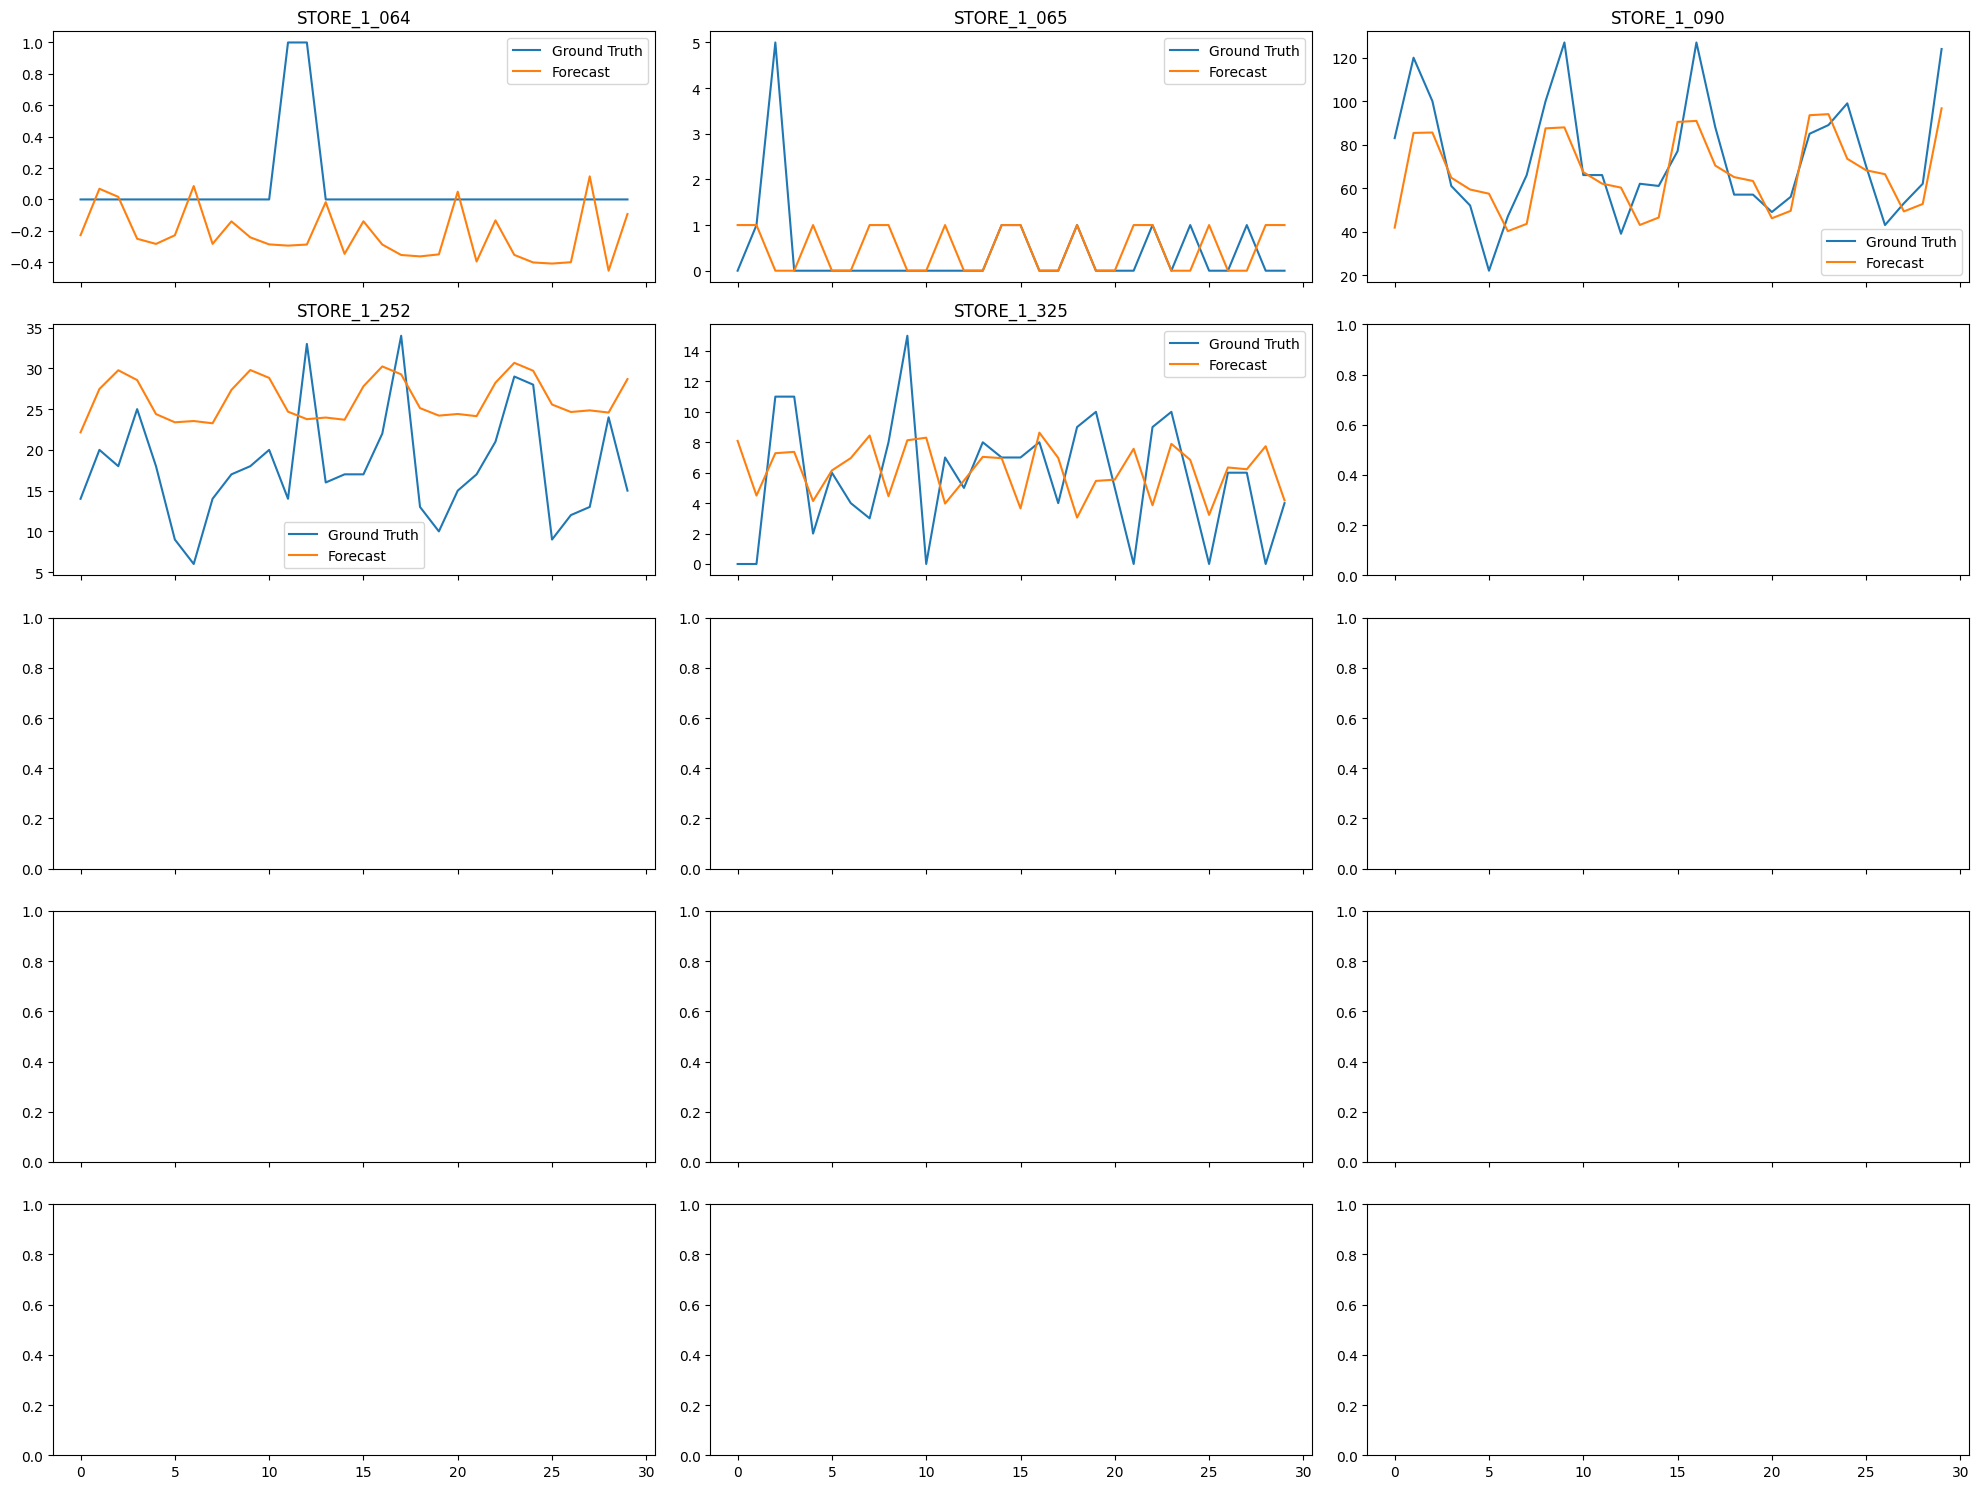

In [ ]:
print("=" * 119)
print(f"{'Results for horizon ' + str(30) + ' days:':^119}")
all_items_evaluation_report(results)
print("=" * 119)
print("\n")

### Forecast horizon = 120 days

In [ ]:
fh = 120
for item_id in tqdm(ITEM_IDS, desc="Items", leave=False):
    param_grid = sarima_params_2_param_grid(item_id_2_sarima_params[item_id])
    cross_validate(
        forecaster=SARIMAX(), param_grid=param_grid, fh=120, item_id=item_id, model_name="sarima", use_custom_cv=True
    )

In [ ]:
results = forecast_and_evaluate(120, "sarima", ["order", "seasonal_order"])

Items:   0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
print("=" * 119)
print(f"{'Results for horizon ' + str(120) + ' days:':^119}")
all_items_evaluation_report(results)
print("=" * 119)
print("\n")

## EMA

EMA - модель экспоненциального скользящего среднего - простая регрессионная модель с модификациями, дающими возможность учитывать тренд/сезонность. Также EMA модели могут описывать мультипликативный тренд/сезонность, благодаря этому они хорошо описывают нестационарные ряды с нелинейным трендом или мультипликативной сезонностью.

В качестве недостатка - в модель нельзя подать дополнительные фичи.

По аналогии с моделью ARIMA подберем оптимальные гиперпараметры по кросс-валидации.

In [ ]:
forecaster = ExponentialSmoothing(sp=7)
param_grid = {
    "trend": ["add", "mul"],
    "seasonal": ["add", "mul"],
    "damped_trend": [True, False],
}

for fh in tqdm(FORECAST_HORIZONS, desc="Horizons", leave=False):
    for item_id in tqdm(ITEM_IDS, desc="Items", leave=False):
        cross_validate(forecaster, param_grid, fh, item_id, model_name="ema", replace_zeros=1, use_custom_cv=True)
clear_output()

In [ ]:
results = {}
for fh in tqdm(FORECAST_HORIZONS, desc="Horizons", leave=False):
    results[fh] = forecast_and_evaluate(fh, model_name="ema", params=["damped_trend", "trend", "seasonal"])
clear_output()

                                              Results for horizon 7 days:                                              


best_params        MAE     SMAPE  \
STORE_1_064  damped_trend=False, seasonal=add, trend=add   1.067431       2.0   
STORE_1_065  damped_trend=False, seasonal=mul, trend=add   1.349388   1.62437   
STORE_1_090  damped_trend=False, seasonal=mul, trend=mul  22.808563  0.380766   
STORE_1_252   damped_trend=True, seasonal=mul, trend=add      7.769  0.456349   
STORE_1_325   damped_trend=True, seasonal=add, trend=mul   3.587104  0.912733   
STORE_1_339  damped_trend=False, seasonal=add, trend=add   1.324846       2.0   
STORE_1_376   damped_trend=True, seasonal=add, trend=add   1.042969  1.552173   
STORE_1_546  damped_trend=False, seasonal=mul, trend=mul   2.719496  0.788827   
STORE_1_547   damped_trend=True, seasonal=mul, trend=add   3.168539  0.581383   
STORE_1_555   damped_trend=True, seasonal=mul, trend=add   6.141111  0.359611   
STORE_1_584  damped_trend=False, seasonal=mul, trend=add   1.299255  1.417625   
STORE_1_586   damped_trend=True, seasonal=add, trend=add  11.779353  0.413528   
STORE_1_587   damped_trend=True, seasonal=mul, trend=add   6.511206  0.257966   
STORE_1_714  damped_trend=False, seasonal=add, trend=mul   5.519606  0.252121   
STORE_1_727  damped_trend=False, seasonal=mul, trend=add   0.869202       2.0   
AVERAGE                                                    5.130471   0.99983   

                   R2  
STORE_1_064       0.0  
STORE_1_065  -0.00261  
STORE_1_090  0.229573  
STORE_1_252 -1.094491  
STORE_1_325  0.122551  
STORE_1_339       0.0  
STORE_1_376 -1.243411  
STORE_1_546  0.330305  
STORE_1_547 -0.304099  
STORE_1_555 -0.064731  
STORE_1_584 -6.391067  
STORE_1_586 -0.730846  
STORE_1_587  0.375218  
STORE_1_714 -1.082395  
STORE_1_727       0.0  
AVERAGE     -0.657067

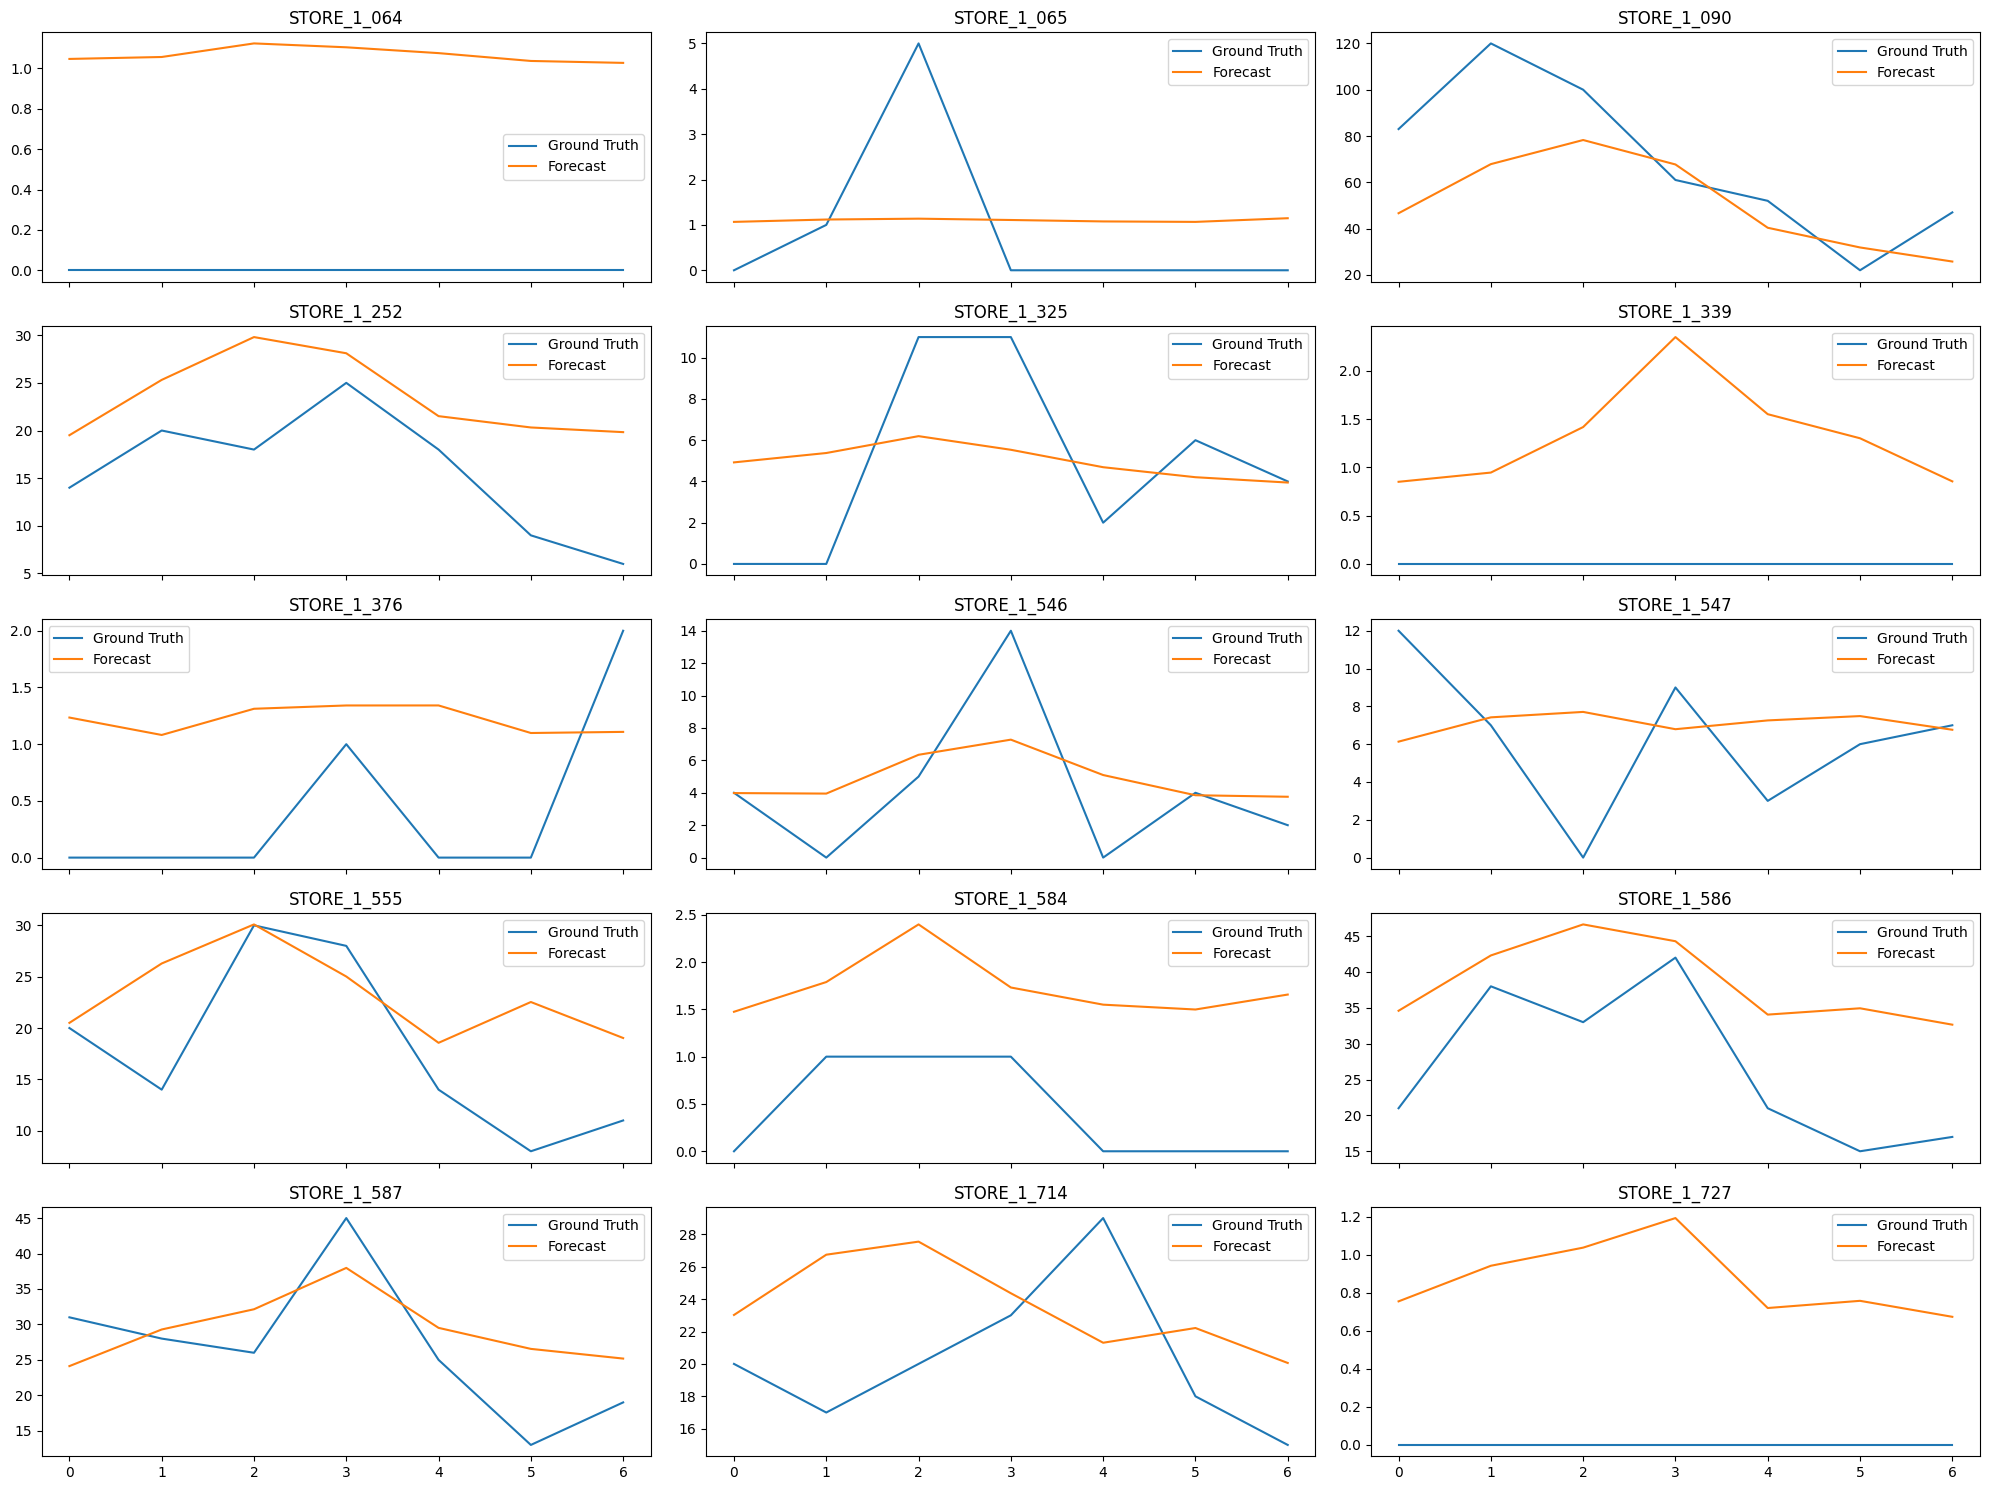



                                             Results for horizon 30 days:                                              


best_params        MAE     SMAPE  \
STORE_1_064  damped_trend=False, seasonal=mul, trend=add   1.000165  1.870323   
STORE_1_065   damped_trend=True, seasonal=mul, trend=add    0.93137  1.526636   
STORE_1_090   damped_trend=True, seasonal=mul, trend=mul  19.453848   0.28293   
STORE_1_252   damped_trend=True, seasonal=mul, trend=add   7.016208  0.371833   
STORE_1_325   damped_trend=True, seasonal=add, trend=add   3.229866  0.738606   
STORE_1_339   damped_trend=True, seasonal=add, trend=add   2.091851  1.448862   
STORE_1_376   damped_trend=True, seasonal=add, trend=add   1.023318  1.405288   
STORE_1_546  damped_trend=False, seasonal=mul, trend=mul   1.820541  0.549997   
STORE_1_547   damped_trend=True, seasonal=mul, trend=mul    8.43796   1.05484   
STORE_1_555   damped_trend=True, seasonal=mul, trend=mul   5.276389  0.245975   
STORE_1_584  damped_trend=False, seasonal=add, trend=add   1.365539  1.088856   
STORE_1_586   damped_trend=True, seasonal=add, trend=add    7.69666  0.241288   
STORE_1_587   damped_trend=True, seasonal=mul, trend=mul   6.018209  0.197443   
STORE_1_714   damped_trend=True, seasonal=mul, trend=add   4.938256  0.205849   
STORE_1_727   damped_trend=True, seasonal=mul, trend=add   4.448125  1.592541   
AVERAGE                                                     4.98322  0.854751   

                    R2  
STORE_1_064 -16.115437  
STORE_1_065  -0.483246  
STORE_1_090   0.177416  
STORE_1_252  -0.387493  
STORE_1_325   0.040673  
STORE_1_339  -0.032257  
STORE_1_376  -0.319824  
STORE_1_546    0.28063  
STORE_1_547  -0.195902  
STORE_1_555   0.108926  
STORE_1_584  -0.062687  
STORE_1_586  -0.046352  
STORE_1_587    0.37531  
STORE_1_714  -0.599954  
STORE_1_727  -0.410296  
AVERAGE      -1.178033

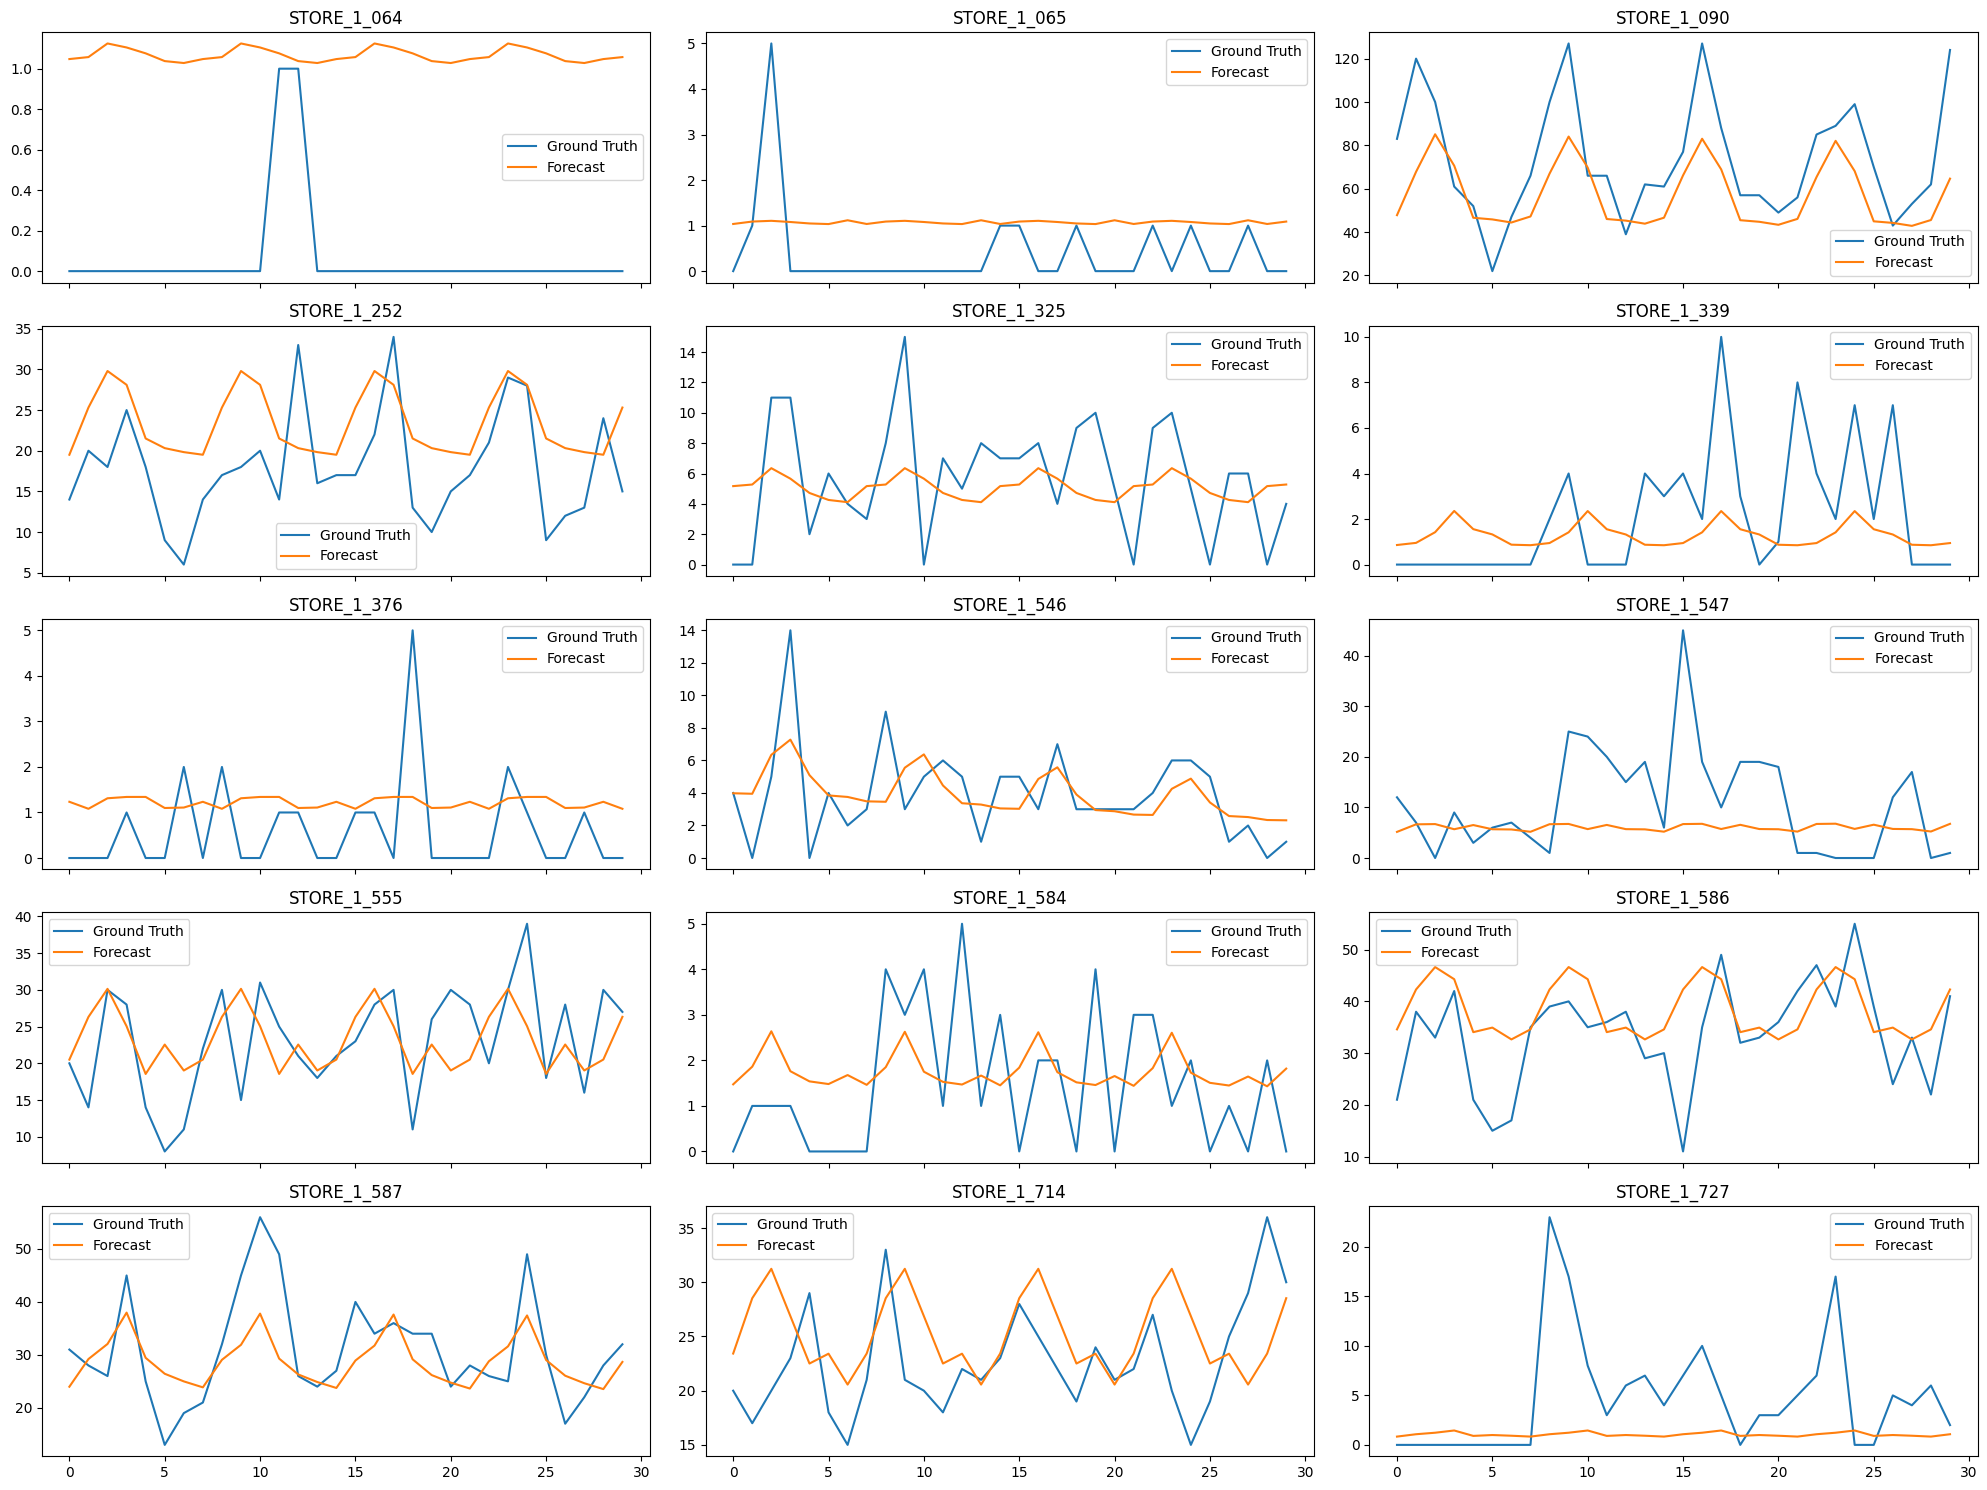



                                             Results for horizon 120 days:                                             


best_params        MAE     SMAPE  \
STORE_1_064  damped_trend=False, seasonal=add, trend=add   0.955945  1.744319   
STORE_1_065   damped_trend=True, seasonal=mul, trend=add   0.955597   1.42912   
STORE_1_090   damped_trend=True, seasonal=mul, trend=mul  31.746042  0.813375   
STORE_1_252   damped_trend=True, seasonal=mul, trend=add   8.877926   0.50742   
STORE_1_325   damped_trend=True, seasonal=add, trend=mul   3.397372  0.737541   
STORE_1_339   damped_trend=True, seasonal=add, trend=add   2.481435   1.14678   
STORE_1_376   damped_trend=True, seasonal=mul, trend=add   1.114606  1.579698   
STORE_1_546   damped_trend=True, seasonal=mul, trend=mul   2.276969  0.668118   
STORE_1_547   damped_trend=True, seasonal=mul, trend=add  10.071113  1.016138   
STORE_1_555   damped_trend=True, seasonal=mul, trend=mul   6.073389  0.277495   
STORE_1_584  damped_trend=False, seasonal=add, trend=add   1.434135    1.0769   
STORE_1_586  damped_trend=False, seasonal=add, trend=add     8.7846  0.278114   
STORE_1_587   damped_trend=True, seasonal=mul, trend=mul   6.882025  0.236783   
STORE_1_714   damped_trend=True, seasonal=mul, trend=add   6.411173  0.307908   
STORE_1_727   damped_trend=True, seasonal=mul, trend=add   3.471267   1.28475   
AVERAGE                                                    6.328906  0.873631   

                   R2  
STORE_1_064 -3.488954  
STORE_1_065 -0.173569  
STORE_1_090  0.138494  
STORE_1_252 -0.831408  
STORE_1_325  0.024926  
STORE_1_339 -0.409168  
STORE_1_376 -0.454441  
STORE_1_546 -0.503669  
STORE_1_547 -0.271685  
STORE_1_555  0.108918  
STORE_1_584  0.058065  
STORE_1_586 -0.071819  
STORE_1_587  0.099972  
STORE_1_714 -0.380597  
STORE_1_727 -0.519012  
AVERAGE      -0.44493

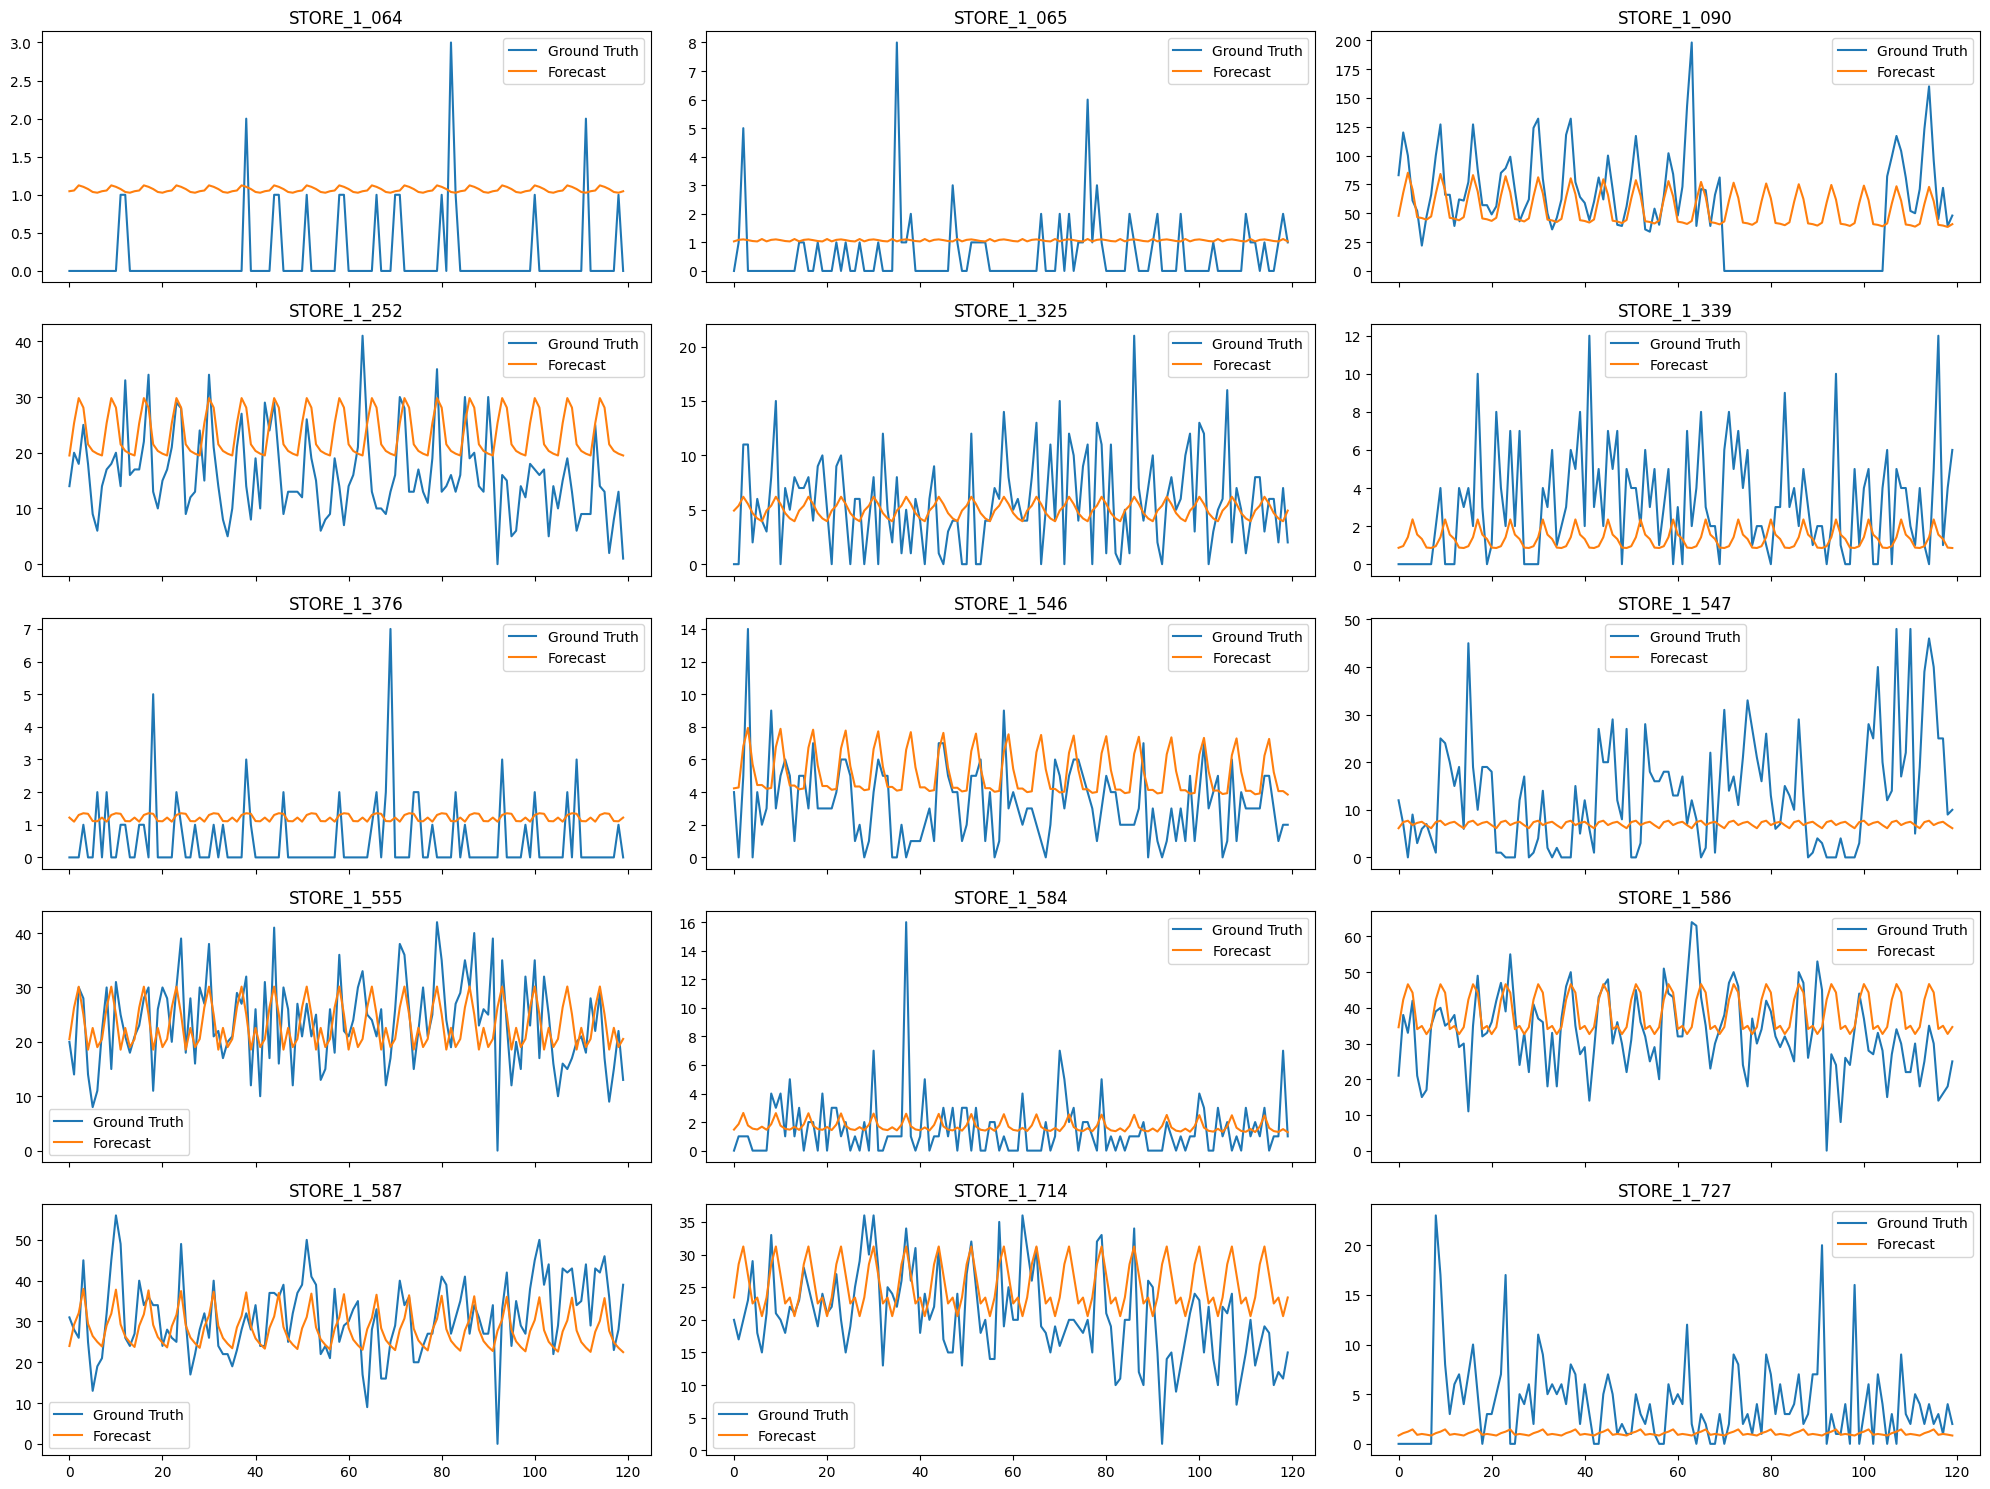

In [ ]:
for fh in FORECAST_HORIZONS:
    print("=" * 119)
    print(f"{'Results for horizon ' + str(fh) + ' days:':^119}")
    all_items_evaluation_report(results[fh])
    print("=" * 119)
    print("\n")

Модель экспоненциального среднего хорошо моделирует недельную сезонность, однако так как у нас по сути еще месячная и годовые циклы, то конечно ошибки довольно существенные.

Но есть отдельные ВР, где модель EMA прям хорошо предсказала:
* STORE_1_587
* STORE_1_090

## SARIMAX

Попробуем еще одну модификацию модели SARIMA, в которую можно дополнительно передать внешние фичи = SARIMA+X.

Вообще говоря, предполагаю, что внесение дополнительных фичей должно повысить качество предсказаний, так как опираться только на сырые данные продаж, не учитывая внешние факторы сложно.

Внесу следующие внешние переменные:
* номер дня недели (1-7)
* номер дня месяца (1-31)
* номер месяца (1-12)

In [ ]:
EXOG_COLS = ["wday", "day", "month", "sell_price"]

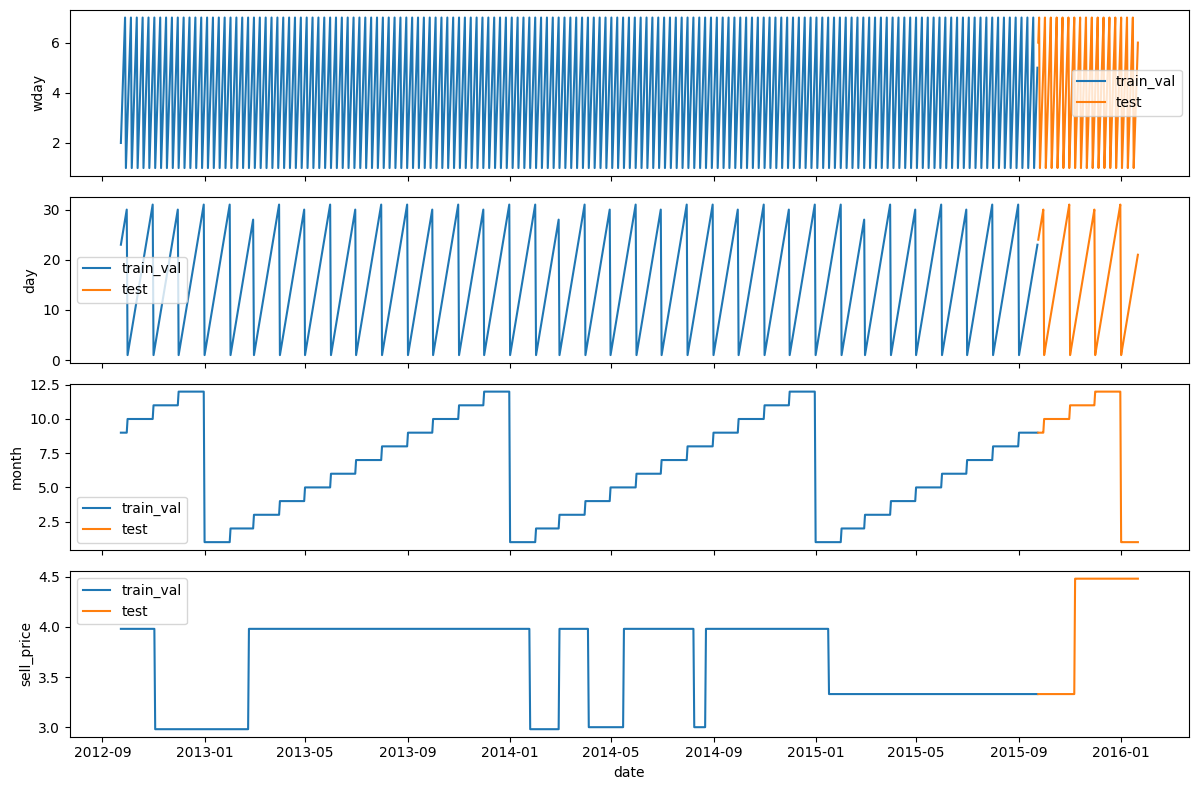

In [ ]:
# Посмотрим на exogenous фичи
train_val_test = ITEM_ID_2_TRAIN_VAL_TEST["STORE_1_727"]

# Ensure 'date' columns are datetime
train_val_test[0]["date"] = pd.to_datetime(train_val_test[0]["date"])
train_val_test[1]["date"] = pd.to_datetime(train_val_test[1]["date"])

train_val_exog = train_val_test[0][EXOG_COLS]
test_exog = train_val_test[1][EXOG_COLS]

fig, axes = plt.subplots(len(EXOG_COLS), 1, figsize=(12, 2 * len(EXOG_COLS)), sharex=True)
for i, col in enumerate(EXOG_COLS):
    axes[i].plot(train_val_test[0]["date"], train_val_exog[col], label="train_val")
    axes[i].plot(train_val_test[1]["date"], test_exog[col], label="test")
    axes[i].set_ylabel(col)
    axes[i].legend()
axes[-1].set_xlabel("date")
plt.tight_layout()
plt.show()

Получается, мы дополнительно внесли недельную (7) и годовые (12) сезонности, а также месячный цикл.

Для тестовой части выборки у нас уже есть значения exogenous переменных - ну и в целом, их не сложно получить (день недели, день в месяце и номер месяца детерминированны, а цена товара тоже задаётся заказчиком).

### Forecast horizon = 7 days

### Forecast horizon = 30 days

### Forecast horizon = 120 days

## Prophet

## Orbit

## Сравнение классических статистических моделей